# Product Recognition on Store Shelves

- Baraghini Nicholas
- Marini Luca

### Import of the libraries

In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

## Step A - Multiple Product Detection:

Load first scene image

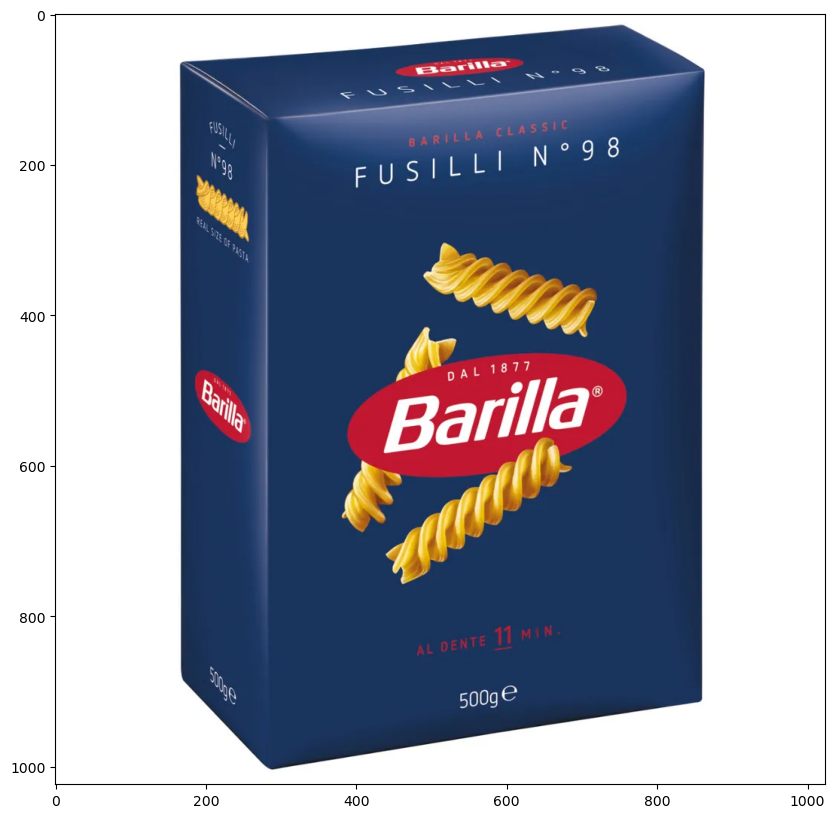

In [22]:
#Load Scene
scene_img = cv2.imread('./scenes/e1.jpg', cv2.COLOR_BGR2RGB)

#Plot Scene
plt.figure(figsize=(20, 10)) 
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB));

Load first model image

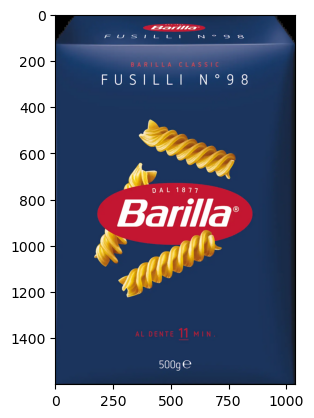

In [23]:
#Load Model
model_img = cv2.imread('./models/0.jpg', cv2.COLOR_BGR2RGB)

#Plot Model
plt.figure() 
plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB));

In [24]:
sift = cv2.SIFT_create()

In [25]:
# model_img = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)
kp_model = sift.detect(model_img)

In [26]:
# Number of keypoints 
print(len(kp_model))

# Location of the keypoint
print(kp_model[0].pt)

# Scale
print(kp_model[0].size)

# Rotation
print(kp_model[0].angle)

1351
(76.4970474243164, 16.92144012451172)
1.8439491987228394
89.87682342529297


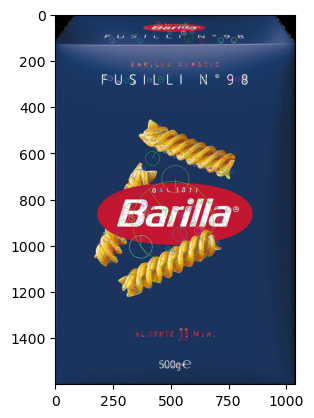

In [27]:
model_img_visualization = cv2.drawKeypoints(model_img, kp_model, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(model_img_visualization, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
# scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
kp_scene = sift.detect(scene_img)

In [29]:
# Verwende spezifisch Scene e1
if 1 in e_scenes_images_features:
    scene_img = e_scenes_images_features[1][0]    # IMAGE_INDEX = 0
    kp_scene = e_scenes_images_features[1][1]     # KEYPOINT_INDEX = 1
    print(f"Verwende Scene e1 mit {len(kp_scene)} keypoints")
    
    # Dein ursprünglicher Code:
    if scene_img is not None and kp_scene is not None and len(kp_scene) > 0:
        scene_img_visualization = cv2.drawKeypoints(scene_img, kp_scene, None,
                                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        if scene_img_visualization is not None:
            plt.figure(figsize=(15, 10))
            plt.imshow(cv2.cvtColor(scene_img_visualization, cv2.COLOR_BGR2RGB))
            plt.title(f'Scene e1 - {len(kp_scene)} SIFT Keypoints')
            plt.axis('off')
            plt.show()
        else:
            print("Fehler beim Zeichnen der Keypoints")
    else:
        print("scene_img oder kp_scene ist nicht verfügbar")
        
else:
    print("Scene e1 ist nicht in e_scenes_images_features verfügbar")
    print("Verfügbare Scenes:", list(e_scenes_images_features.keys()) if 'e_scenes_images_features' in locals() else "Keine")

NameError: name 'e_scenes_images_features' is not defined

In [47]:
#Plot Scene
#plt.figure(figsize=(20, 10)) 
#plt.imshow(cv2.cvtColor(scene,cv2.COLOR_BGR2RGB))

In [48]:
kp_model, des_model = sift.compute(model_img, kp_model)
kp_scene, des_scene = sift.compute(scene_img, kp_scene)

In [49]:
print("Number of model descriptors: ", len(des_model))
print("Dimensionality of a SIFT descriptor: ", des_model[0].shape)
print("Type of the descriptor: ", des_model[0].dtype)

Number of model descriptors:  8047
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


Defining a function which find matches between keypoints belonging to the model, with keypoints belonging to the scene, and through a threshold collects all the worth considered matches in a list, which is then returned by the function itself

In [50]:
def Matching(Model_Descriptors, Scene_Descriptors, Treshold = 0.45, k=2):
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
        # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(Model_Descriptors, Scene_Descriptors, k)
        #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good = []
    for m,n in matches:
        if m.distance < Treshold * n.distance: #  if m.distance/n.distance < Threshold:
            good.append(m)
            
    return good

In [51]:
good = Matching(des_model, des_scene)

In [52]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 30
print(len(good))
if len(good)>MIN_MATCH_COUNT:
    
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    
    # Corners of the query image
    h,w = model_img.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography

    # Drawing the bounding box
    scene_img = cv2.polylines(scene_img, [np.int32(dst)],True, (0, 255, 0), 3, cv2.LINE_AA)
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

153


In [110]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(model_img, kp_model, scene_img, kp_scene, good, None, **draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [111]:
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Creation of some dictionaries that contain all the keypoint, descriptors and images that we will need during stepA, so that they are loaded once and at the beginning, to save later computational cost.

In [70]:
NUM_OF_MODELS = 28

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
TRESHOLD_INDEX = 5

# Dictionary that contains the image, all keypoints and descriptors for each model images
model_images_features = {}
mean_of_model_intensities_r_g_b = {}

for i in range(NUM_OF_MODELS):
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2GRAY)#cv2.COLOR_BGR2RGB)
    kp_model = sift.detect(model_img)
    kp_model, des_model = sift.compute(model_img, kp_model)
    model_images_features[i] = [model_img, kp_model, des_model]
    
    b,g,r = cv2.split(model_images_features[i][IMAGE_INDEX])
    # save the mean of the intensities (divided per channel) for every model image
    mean_of_model_intensities_r_g_b[i] = [np.mean(r), np.mean(g), np.mean(b)]
    # print(mean_of_model_intensities_r_g_b[i][0], mean_of_model_intensities_r_g_b[i][1], mean_of_model_intensities_r_g_b[i][2])
    # print(model_images_features[i][IMAGE_INDEX][0].shape)
    # print(mean_of_model_intensities[i])

    
    # plt.imshow(cv2.cvtColor(model_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

In [71]:
scenes_to_test = [1, 2, 3, 4, 5, 6]

# Dictionary that contains the image, all keypoints and descriptors for each easy scene image
e_scenes_images_features = {}

for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/e{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    e_scenes_images_features[i] = [scene_img, kp_scene, des_scene]
    # scene_img_visualization = cv2.drawKeypoints(scene_img,kp_e_scemes_images['1'],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(cv2.cvtColor(e_scenes_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

[ WARN:0@1112.351] global loadsave.cpp:268 findDecoder imread_('./scenes/e6.png'): can't open/read file: check file path/integrity


Function that will output the position in the image reference system of each instance 

In [72]:
def print_result(e_results, idx_of_scene):
    for i in models_to_test:
        print('Product {} - {} instance/s found:'.format(i, e_results[idx_of_scene][i]['count']))
        n = 0
        if e_results[idx_of_scene][i].get('width', None):
            n += 1
            print('\tInstance {} position: {}, width: {}px, height: {}px'.format(n, e_results[idx_of_scene][i]['pos'], e_results[idx_of_scene][i]['width'], e_results[idx_of_scene][i]['height']))
    print('_' * 80 + '\n')

In [73]:
def distance_2_points(A, B):
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

In [74]:
# function that plots the final merged bounding boxes
def plot_final_bounding_boxes(img, final_corners_of_bounding_boxes, difficulty_scenes_images_features, j, thickness=20):
    print('Final corners of bounding boxes:')
    print(final_corners_of_bounding_boxes)
    
    if img is None:
        img = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX])
    print(img.shape)

    
    # print final bounding boxes on an image
    for top_left_corner, bottom_right_corner in final_corners_of_bounding_boxes:
        scene_img_with_FINAL_bounding_boxes = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), thickness)

    
    
    # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
    if(len(final_corners_of_bounding_boxes) > 0):
        print('  - Found {} instances of model {} in scene {}'.format(len(final_corners_of_bounding_boxes),i,j))
        # plotting the bounding box
        plt.imshow(cv2.cvtColor(scene_img_with_FINAL_bounding_boxes, cv2.COLOR_BGR2RGB))
        plt.show()
        
        return scene_img_with_FINAL_bounding_boxes
    else:
        print('  - Model {} NOT found in the scene {}'.format(i,j))
        return None

In [75]:
# function that solves exceeding dimensions of bounding_boxes in scene
def solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, difficulty_scenes_images_features):
    final_corners_of_bounding_boxes_without_exceeding_dimensions = []
    # adjust bounding boxes that go out the dimensions of the scene image
    scene_height = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[0]
    scene_width = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[1]

    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
        fin_top_left_corner = list(fin_top_left_corner)
        fin_bottom_right_corner = list(fin_bottom_right_corner)
        # top left corner that goes out on the left of the scene image
        if fin_top_left_corner[0] < 0:
            fin_top_left_corner[0] = 0
        # bottom right corner that goes out on the left of the scene image
        if fin_bottom_right_corner[0] < 0:
            fin_bottom_right_corner[0] = 0
        # top left corner that goes out on the right of the scene image
        if fin_top_left_corner[0] > scene_width:
            fin_top_left_corner[0] = scene_width
        # bottom right corner that goes out on the right of the scene image
        if fin_bottom_right_corner[0] > scene_width:
            fin_bottom_right_corner[0] = scene_width
        # top left corner that goes out on the top of the scene image
        if fin_top_left_corner[1] < 0:
            fin_top_left_corner[1] = 0
        # bottom right corner that goes out on the top of the scene image
        if fin_bottom_right_corner[1] < 0:
            fin_bottom_right_corner[1] = 0  
        # top left corner that goes out on the bottom of the scene image
        if fin_top_left_corner[1] > scene_height:
            fin_top_left_corner[1] = scene_height
        # bottom right corner that goes out on the bottom of the scene image
        if fin_bottom_right_corner[1] > scene_height:
            fin_bottom_right_corner[1] = scene_height

        fin_top_left_corner = tuple(fin_top_left_corner)
        fin_bottom_right_corner = tuple(fin_bottom_right_corner)
        final_corners_of_bounding_boxes_without_exceeding_dimensions.append([ (int(fin_top_left_corner[0]), 
                                                                               int(fin_top_left_corner[1])), 
                                                                             (int(fin_bottom_right_corner[0]), 
                                                                              int(fin_bottom_right_corner[1]))])
    return final_corners_of_bounding_boxes_without_exceeding_dimensions

In [76]:
def solve_color_problem(final_corners_of_bounding_boxes_without_exceeding_dimensions, difficulty_scenes_images_features, j):
    final_corners_of_bounding_boxes_after_color_problem = []
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
    
        # print('fin top left: ', fin_top_left_corner)
        # print('fin bottom right: ', fin_bottom_right_corner)
        # print(m_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
        #                                                           fin_top_left_corner[0]:fin_bottom_right_corner[0]].shape)

        # r, g , b intensities of current bounding box found in scene 
        b_b_box,g_b_box,r_b_box = cv2.split(
            difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                   fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        
        # r, g , b mean intensities of current bounding box found in scene
        mean_r_b_box = np.mean(r_b_box)
        mean_g_b_box = np.mean(g_b_box)
        mean_b_b_box = np.mean(b_b_box)

        # compute the difference of intensity by using the 3 channels r,g,b of bounding box and model image
        # print('mean_r_b_box: ', mean_r_b_box)
        # print('mean_g_b_box: ', mean_g_b_box)
        # print('mean_b_b_box: ', mean_b_b_box)

        diff_r = np.absolute(mean_of_model_intensities_r_g_b[i][0] - mean_r_b_box)
        diff_g = np.absolute(mean_of_model_intensities_r_g_b[i][1] - mean_g_b_box)
        diff_b = np.absolute(mean_of_model_intensities_r_g_b[i][2] - mean_b_b_box)

        print('diff_r: ', diff_r)
        print('diff_g: ', diff_g)
        print('diff_b: ', diff_b)

        # I consider a bounding box as good if and only if the difference of the intiensities from the model,
        # in all 3 channels, are below a certain treshold
        if diff_r <= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES and diff_g <= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES and \
        diff_b <= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
            final_corners_of_bounding_boxes_after_color_problem.append([ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                                        (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    return final_corners_of_bounding_boxes_after_color_problem

In [77]:
# function that split an image into (n_bins_heigth x n_bins_width) bins and returns a dictonary
# that contains the means of the 3 color channels of the (n_bins_heigth x n_bins_width) bins
def split_image_into_N_x_M_bins_with_intensity_means(image, n_bins_width = 3, n_bins_heigth = 4):
    img_N_x_M_bins = {}
    
    img2 = np.copy(image)
    
    img_width = image.shape[1]
    img_height = image.shape[0]
    
    step_width = int(img_width / n_bins_width)
    step_height = int(img_height / n_bins_heigth)
    
    r = 0
    c = 0
    
    print('img_height: ', img_height)
    print('step_height: ', step_height)
    if img_height != 0 and step_height != 0 and img_width != 0 and step_width != 0:
        for row in np.arange(0, img_height, step_height):
            c = 0
            cv2.line(img2,(0, row),(img_width, row),(0,0,0),3) 
            for col in np.arange(0, img_width, step_width):
                # print('row {} col {}'.format(r,c))
                if row + 2 * step_height > img_height and col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col:])

                elif row + 2 * step_height > img_height:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col : col + step_width])

                elif col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row : row + step_height, col :])
                else:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(
                        image[row : row + step_height, col : col + step_width])

                cv2.line(img2,(col, 0),(col, img_height),(0,0,0),3) 
                if r < n_bins_heigth and c < n_bins_width:
                    # save means of the 3 channels (r,g,b) of each bin
                    img_N_x_M_bins[r, c] = (np.mean(partial_r_channel), np.mean(partial_g_channel), np.mean(partial_b_channel))
                    # IF YOU WANT TO VISUALIZE EACH BIN UNCOMMENT THE FOLLOWING LINES:
                    # plot each bin in blue channel color
                    # plt.imshow(cv2.cvtColor(partial_b_channel, cv2.COLOR_BGR2RGB))
                    # plt.show()

                    # salva le medie e non le immagini dei bins

                c += 1
            r += 1
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.show()  
    return img_N_x_M_bins
        

In [78]:
def solve_color_problem_with_N_x_M_bins(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                    difficulty_scenes_images_features, i, j, N=3, M=4, 
                                    COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=50):
    final_corners_of_bounding_boxes_after_color_problem = []
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
    
        means_bins_model_img = split_image_into_N_x_M_bins_with_intensity_means(
            model_images_features[i][IMAGE_INDEX], 
            N, M)
        
        print(fin_top_left_corner[1], fin_top_left_corner[0], fin_bottom_right_corner[1], fin_bottom_right_corner[0])
        
        means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity_means(
            difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                   fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
            N, M)
    
        if not means_bins_scene_img or not means_bins_scene_img:
            return []
    
        good = True
        
        # cycle the model dictionary and get the diff of the means by getting the keys of the scene dictionary
        for k, v in means_bins_model_img.items():
            means_k_scene = means_bins_scene_img.get(k)
            # I consider a bounding box as good if and only if all the difference of the intiensities from the 
            # bins of the model, in all 3 channels, are below a certain treshold
            diff_r = np.absolute(v[0] - means_k_scene[0])
            diff_g = np.absolute(v[1] - means_k_scene[1])
            diff_b = np.absolute(v[2] - means_k_scene[2])
            
            print('Bin ({}, {}):'.format(k[0], k[1]))
            print('  - diff_r: ', diff_r)
            print('  - diff_g: ', diff_g)
            print('  - diff_b: ', diff_b)
            
            # PRINT ALL THE DIFFERENCES
            # print('diff_r: ', diff_r)
            # print('diff_g: ', diff_g)
            # print('diff_b: ', diff_b)
            
            if diff_r >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or diff_g >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                diff_b >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
                print('___________________NO GOOD___________________')
                good = False
            
        if good:
            final_corners_of_bounding_boxes_after_color_problem.append([ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                                        (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [79]:
# dictionary that will contain the output to be printed
e_results = {}    

In [80]:
'''
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = [0, 1, 11, 19, 24, 26, 25] # [0,11,25]
scenes_to_test = [1,2,3,4,5] # [2,3,4]
MATCHING_TRESHOLD = 0.45

MIN_NUM_OF_MATCHES = 15

COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 77

N_BINS_ON_WIDTH = 3

M_BINS_ON_HEIGHT = 4

final_scene_images_with_bb = {}

for j in scenes_to_test:
    final_scene_images_with_bb[j] = np.copy(e_scenes_images_features[j][IMAGE_INDEX])
    e_results[j] = {}
    for i in models_to_test:
        print('_' * 80 + '\n')
        
        e_results[j][i] = {}
        e_results[j][i]['count'] = 0
        
        good = Matching(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], 
                        Treshold = MATCHING_TRESHOLD, k=2)#flann.knnMatch(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], k=2)
        # Checking if we found enough matching
        MIN_MATCH_COUNT = MIN_NUM_OF_MATCHES
        
        # If enough matches => the model is in the scene image
        if len(good) >= MIN_MATCH_COUNT:
            
            
            
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ e_scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()

            # Corners of the query image
            h,w = model_images_features[i][IMAGE_INDEX].shape[:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image
            
            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography          
            
            # Drawing the bounding box
            #scene_img = cv2.polylines(e_scenes_images_features[j][IMAGE_INDEX], [np.int32(dst)],
                                      #True, (0, 255, 0), 3, cv2.LINE_AA)
            #e_results[j][i]['pos']
            top_left_bound_box_corner = dst[0][0]
            bottom_left_bound_box_corner = dst[1][0]
            top_right_bound_box_corner = dst[3][0]
            bottom_right_bound_box_corner = dst[2][0]
            # print(top_left_bound_box_corner)
            
            
            # compute width and height of the current bounding box
            width_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, top_right_bound_box_corner))
            height_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, bottom_left_bound_box_corner))
            
            # I consider the current bounding box as good only if it has a shape of a rectangle, 
            # with an height > of the width, as the cereal boxes
            if width_of_bounding_box < height_of_bounding_box:
            
                final_corners_of_bounding_boxes = []
                final_corners_of_bounding_boxes.append([top_left_bound_box_corner, bottom_right_bound_box_corner])
                final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, e_scenes_images_features)

                
                # solve color problem with bins
                
                final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
                    final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                    e_scenes_images_features, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                    COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES)
                

                
                # solve color problem without bins (as an unique image)
                #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem(
                #    final_corners_of_bounding_boxes_without_exceeding_dimensions, e_scenes_images_features, j)

                if len(final_corners_of_bounding_boxes_after_color_problem) > 0:
                    for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_after_color_problem:
                        e_results[j][i]['count'] += 1

                        # Save width and height measures of the bounding box
                        e_results[j][i]['width'] = width_of_bounding_box
                        e_results[j][i]['height'] = height_of_bounding_box

                        # Save the position of the bounding box
                        e_results[j][i]['pos'] = (int(fin_top_left_corner[0]), int(fin_top_left_corner[1]))


                print('COLOR CORRECTION DONE:')
                img_bb = plot_final_bounding_boxes(final_scene_images_with_bb[j], final_corners_of_bounding_boxes_after_color_problem, 
                                          e_scenes_images_features, j)
                if img_bb is not None:
                    final_scene_images_with_bb[j] = img_bb
            
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

        # Drawing the matches
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None, # not draw keypoints only matching lines
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2) # not draw keypoints only lines
        img3 = cv2.drawMatches(model_images_features[i][IMAGE_INDEX], 
                               model_images_features[i][KEYPOINT_INDEX], 
                               e_scenes_images_features[j][IMAGE_INDEX], 
                               e_scenes_images_features[j][KEYPOINT_INDEX],
                               good, 
                               None,  
                               **draw_params)
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.show()
'''

'\nIMAGE_INDEX      = 0\nKEYPOINT_INDEX   = 1\nDESCRIPTOR_INDEX = 2\n\nmodels_to_test = [0, 1, 11, 19, 24, 26, 25] # [0,11,25]\nscenes_to_test = [1,2,3,4,5] # [2,3,4]\nMATCHING_TRESHOLD = 0.45\n\nMIN_NUM_OF_MATCHES = 15\n\nCOLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 77\n\nN_BINS_ON_WIDTH = 3\n\nM_BINS_ON_HEIGHT = 4\n\nfinal_scene_images_with_bb = {}\n\nfor j in scenes_to_test:\n    final_scene_images_with_bb[j] = np.copy(e_scenes_images_features[j][IMAGE_INDEX])\n    e_results[j] = {}\n    for i in models_to_test:\n        print(\'_\' * 80 + \'\n\')\n        \n        e_results[j][i] = {}\n        e_results[j][i][\'count\'] = 0\n        \n        good = Matching(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], \n                        Treshold = MATCHING_TRESHOLD, k=2)#flann.knnMatch(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], k=2)\n        # Checking if we found enough matching\n        MIN_MATCH_COUNT =

In [82]:
# function that plots the final merged bounding boxes
def plot_dark_area_bounding_boxes(img, final_corners_of_bounding_boxes, difficulty_scenes_images_features, j):
    print('Final corners of bounding boxes:')
    print(final_corners_of_bounding_boxes)
    
    
    # print final bounding boxes on an image
    for top_left_corner, bottom_right_corner in final_corners_of_bounding_boxes:
        scene_img_with_FINAL_bounding_boxes = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,0,0), -1)

    
    
    # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
    if(len(final_corners_of_bounding_boxes) > 0):
        print('  - Found {} instances of model {} in scene {}'.format(len(final_corners_of_bounding_boxes),i,j))
        # plotting the bounding box
        plt.imshow(cv2.cvtColor(scene_img_with_FINAL_bounding_boxes, cv2.COLOR_BGR2RGB))
        plt.show()
        
        return scene_img_with_FINAL_bounding_boxes
    else:
        print('  - Model {} NOT found in the scene {}'.format(i,j))
        return None

In [20]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

# Füge dies hinzu, wenn h_scenes_images_features noch nicht definiert ist
if 'h_scenes_images_features' not in globals():
    h_scenes_images_features = {}

models_to_test = [0,1,11, 19, 24, 26, 25, 27] #[1] #, 1, 11, 19, 24, 26, 25] # [0,11,25]
scenes_to_test = [1,2,3,4,5,6] # [2,3,4]
MATCHING_TRESHOLD = 0.45

MIN_NUM_OF_MATCHES = 18

COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 79

N_BINS_ON_WIDTH = 3

M_BINS_ON_HEIGHT = 4

final_scene_images_with_bb = {}

scene_single_model_features = {}

print("="*80)
print("TESTE EASY SCENES (e1-e6)")
print("="*80)

for j in scenes_to_test:
    # Prüfe ob Easy Scene existiert
    if j not in e_scenes_images_features:
        print(f"⚠️ WARNUNG: Easy Scene e{j} nicht gefunden! Überspringe...")
        continue
        
    final_scene_images_with_bb[j] = np.copy(e_scenes_images_features[j][IMAGE_INDEX])
    e_results[j] = {}
    for i in models_to_test:
        # Prüfe ob Model existiert
        if i not in model_images_features:
            print(f"⚠️ WARNUNG: Model {i} nicht gefunden! Überspringe...")
            continue
            
        scene_single_model = np.copy(e_scenes_images_features[j][IMAGE_INDEX])
        print('_' * 80 + '\n')
        print('Finding model {} in easy scene e{}'.format(i,j))
        
        e_results[j][i] = {}
        e_results[j][i]['count'] = 0
        
         # Checking if we found enough matching
        MIN_MATCH_COUNT = MIN_NUM_OF_MATCHES
        
        finding = True
        
        # If enough matches => the model is in the scene image
        while finding:
            # Check if the image is valid before processing
            if scene_single_model is None or (isinstance(scene_single_model, np.ndarray) and scene_single_model.dtype == object and scene_single_model.size == 1 and scene_single_model[()] is None):
                print(f"Scene image for scene {j} is None. Skipping.")
                break

            kp_scene = sift.detect(scene_single_model)
            kp_scene, des_scene = sift.compute(scene_single_model, kp_scene)
            scene_single_model_features[j] = [scene_single_model, kp_scene, des_scene]
            
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], scene_single_model_features[j][DESCRIPTOR_INDEX], 
                            Treshold = MATCHING_TRESHOLD, k=2)#flann.knnMatch(model_images_features[i][DESCRIPTOR_INDEX], e_scenes_images_features[j][DESCRIPTOR_INDEX], k=2)
            print(len(good))
            
            if len(good) < MIN_MATCH_COUNT:
                finding = False
                
            
            if len(good) >= MIN_MATCH_COUNT:
                
                

                # building the corrspondences arrays of good matches
                src_pts = np.float32([ model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                dst_pts = np.float32([ scene_single_model_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)

                # Using RANSAC to estimate a robust homography. 
                # It returns the homography M and a mask for the discarded points
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Mask of discarded point used in visualization
                matchesMask = mask.ravel().tolist()

                # Corners of the query image
                h,w = model_images_features[i][IMAGE_INDEX].shape[:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image

                # Projecting the corners into the train image
                dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography          

                # Drawing the bounding box
                #scene_img = cv2.polylines(e_scenes_images_features[j][IMAGE_INDEX], [np.int32(dst)],
                                          #True, (0, 255, 0), 3, cv2.LINE_AA)
                #e_results[j][i]['pos']
                top_left_bound_box_corner = dst[0][0]
                bottom_left_bound_box_corner = dst[1][0]
                top_right_bound_box_corner = dst[3][0]
                bottom_right_bound_box_corner = dst[2][0]
                # print(top_left_bound_box_corner)


                # compute width and height of the current bounding box
                width_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, top_right_bound_box_corner))
                height_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, bottom_left_bound_box_corner))

                # I consider the current bounding box as good only if it has a shape of a rectangle, 
                # with an height > of the width, as the cereal boxes
                if width_of_bounding_box < height_of_bounding_box:

                    final_corners_of_bounding_boxes = []
                    final_corners_of_bounding_boxes.append([top_left_bound_box_corner, bottom_right_bound_box_corner])
                    final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, e_scenes_images_features)


                    # solve color problem with bins

                    final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
                        final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                        e_scenes_images_features, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                        COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES)



                    # solve color problem without bins (as an unique image)
                    #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem(
                    #    final_corners_of_bounding_boxes_without_exceeding_dimensions, e_scenes_images_features, j)

                    if len(final_corners_of_bounding_boxes_after_color_problem) > 0:
                        finding = False
                        for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_after_color_problem:
                            e_results[j][i]['count'] += 1

                            # Save width and height measures of the bounding box
                            e_results[j][i]['width'] = width_of_bounding_box
                            e_results[j][i]['height'] = height_of_bounding_box

                            # Save the position of the bounding box
                            e_results[j][i]['pos'] = (int(fin_top_left_corner[0]), int(fin_top_left_corner[1]))

                    else:
                        print('NO CORNERS AFTER COLOR CORRECTION')
                        for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_without_exceeding_dimensions:
                            scene_single_model = plot_dark_area_bounding_boxes(scene_single_model, 
                                                                               final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                                               e_scenes_images_features, j)
                        #plt.imshow(cv2.cvtColor(scene_single_model, cv2.COLOR_BGR2RGB))
                        #plt.show()

                    print('COLOR CORRECTION DONE:')
                    img_bb = plot_final_bounding_boxes(final_scene_images_with_bb[j], final_corners_of_bounding_boxes_after_color_problem, 
                                              e_scenes_images_features, j)
                    if img_bb is not None:
                        final_scene_images_with_bb[j] = img_bb

            else:
                print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
                matchesMask = None

            # Drawing the matches
            draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                               singlePointColor = None, # not draw keypoints only matching lines
                               matchesMask = matchesMask, # draw only inliers
                               flags = 2) # not draw keypoints only lines
            img3 = cv2.drawMatches(model_images_features[i][IMAGE_INDEX], 
                                   model_images_features[i][KEYPOINT_INDEX], 
                                   e_scenes_images_features[j][IMAGE_INDEX], 
                                   e_scenes_images_features[j][KEYPOINT_INDEX],
                                   good, 
                                   None,  
                                   **draw_params)
            #plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
            #plt.show()

# ============================================================================
# HARD SCENES TESTING (zusätzlich für h1-h6)
# ============================================================================

hard_scenes_to_test = [1,2,3,4,5,6]  # Teste auch h6
final_hard_scene_images_with_bb = {}
hard_scene_single_model_features = {}
h_results = {}  # Neue Variable für Hard Scene Ergebnisse

print("\n" + "="*80)
print("TESTE HARD SCENES (h1-h6)")
print("="*80)

for j in hard_scenes_to_test:
    # Prüfe ob Hard Scene existiert
    if j not in h_scenes_images_features:
        print(f"⚠️ WARNUNG: Hard Scene h{j} nicht gefunden! Überspringe...")
        continue
        
    print(f"\n--- TESTE HARD SCENE h{j} ---")
    
    final_hard_scene_images_with_bb[j] = np.copy(h_scenes_images_features[j][IMAGE_INDEX])
    h_results[j] = {}
    
    for i in models_to_test:
        # Prüfe ob Model existiert
        if i not in model_images_features:
            print(f"⚠️ WARNUNG: Model {i} nicht gefunden! Überspringe...")
            continue
            
        scene_single_model = np.copy(h_scenes_images_features[j][IMAGE_INDEX])
        print('_' * 80 + '\n')
        print('Finding model {} in hard scene h{}'.format(i,j))
        
        h_results[j][i] = {}
        h_results[j][i]['count'] = 0
        
        MIN_MATCH_COUNT = MIN_NUM_OF_MATCHES
        finding = True
        
        # If enough matches => the model is in the scene image
        while finding:
            # Check if the image is valid before processing
            if scene_single_model is None or (isinstance(scene_single_model, np.ndarray) and scene_single_model.dtype == object and scene_single_model.size == 1 and scene_single_model[()] is None):
                print(f"Scene image for hard scene h{j} is None. Skipping.")
                break

            kp_scene = sift.detect(scene_single_model)
            kp_scene, des_scene = sift.compute(scene_single_model, kp_scene)
            hard_scene_single_model_features[j] = [scene_single_model, kp_scene, des_scene]
            
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], 
                           hard_scene_single_model_features[j][DESCRIPTOR_INDEX], 
                           Treshold = MATCHING_TRESHOLD, k=2)
            print(f"Matches gefunden: {len(good)}")
            
            if len(good) < MIN_MATCH_COUNT:
                finding = False
                
            if len(good) >= MIN_MATCH_COUNT:
                # building the correspondences arrays of good matches
                src_pts = np.float32([model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt for m in good]).reshape(-1,1,2)
                dst_pts = np.float32([hard_scene_single_model_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good]).reshape(-1,1,2)

                # Using RANSAC to estimate a robust homography
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                if M is not None:
                    # Mask of discarded point used in visualization
                    matchesMask = mask.ravel().tolist()

                    # Corners of the query image
                    h,w = model_images_features[i][IMAGE_INDEX].shape[:2]
                    pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)

                    # Projecting the corners into the train image
                    dst = cv2.perspectiveTransform(pts,M)

                    top_left_bound_box_corner = dst[0][0]
                    bottom_left_bound_box_corner = dst[1][0]
                    top_right_bound_box_corner = dst[3][0]
                    bottom_right_bound_box_corner = dst[2][0]

                    # compute width and height of the current bounding box
                    width_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, top_right_bound_box_corner))
                    height_of_bounding_box = int(distance_2_points(top_left_bound_box_corner, bottom_left_bound_box_corner))

                    # I consider the current bounding box as good only if it has a shape of a rectangle, 
                    # with a height > width, as the cereal boxes
                    if width_of_bounding_box < height_of_bounding_box:

                        final_corners_of_bounding_boxes = []
                        final_corners_of_bounding_boxes.append([top_left_bound_box_corner, bottom_right_bound_box_corner])
                        
                        # WICHTIG: Verwende h_scenes_images_features statt e_scenes_images_features!
                        final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(
                            final_corners_of_bounding_boxes, h_scenes_images_features)

                        # solve color problem with bins (für Hard Scenes)
                        final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
                            final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                            h_scenes_images_features, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                            COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES)

                        if len(final_corners_of_bounding_boxes_after_color_problem) > 0:
                            finding = False
                            for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_after_color_problem:
                                h_results[j][i]['count'] += 1

                                # Save width and height measures of the bounding box
                                h_results[j][i]['width'] = width_of_bounding_box
                                h_results[j][i]['height'] = height_of_bounding_box

                                # Save the position of the bounding box
                                h_results[j][i]['pos'] = (int(fin_top_left_corner[0]), int(fin_top_left_corner[1]))

                        else:
                            print('NO CORNERS AFTER COLOR CORRECTION')
                            for [fin_top_left_corner, fin_bottom_right_corner] in final_corners_of_bounding_boxes_without_exceeding_dimensions:
                                scene_single_model = plot_dark_area_bounding_boxes(scene_single_model, 
                                                                                   final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                                                   h_scenes_images_features, j)

                        print('COLOR CORRECTION DONE:')
                        img_bb = plot_final_bounding_boxes(final_hard_scene_images_with_bb[j], 
                                                          final_corners_of_bounding_boxes_after_color_problem, 
                                                          h_scenes_images_features, j)
                        if img_bb is not None:
                            final_hard_scene_images_with_bb[j] = img_bb

            else:
                print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
                matchesMask = None

            # Drawing the matches
            draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                               singlePointColor = None, # not draw keypoints only matching lines
                               matchesMask = matchesMask, # draw only inliers
                               flags = 2) # not draw keypoints only lines
            img3 = cv2.drawMatches(model_images_features[i][IMAGE_INDEX], 
                                   model_images_features[i][KEYPOINT_INDEX], 
                                   h_scenes_images_features[j][IMAGE_INDEX], 
                                   h_scenes_images_features[j][KEYPOINT_INDEX],
                                   good, 
                                   None,  
                                   **draw_params)
            #plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
            #plt.show()

print("\n" + "="*80)
print("TESTING ABGESCHLOSSEN")
print("Easy Scenes (e1-e6): e_results verfügbar")
print("Hard Scenes (h1-h6): h_results verfügbar")
print("="*80)

TESTE EASY SCENES (e1-e6)


NameError: name 'e_scenes_images_features' is not defined

Final output of StepA

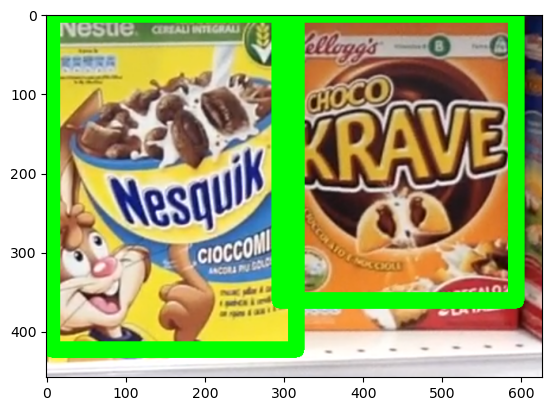

Product 0 - 1 instance/s found:
	Instance 1 position: (7, 0), width: 311px, height: 438px
Product 1 - 0 instance/s found:
Product 11 - 1 instance/s found:
	Instance 1 position: (295, 0), width: 296px, height: 394px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 0 instance/s found:
________________________________________________________________________________



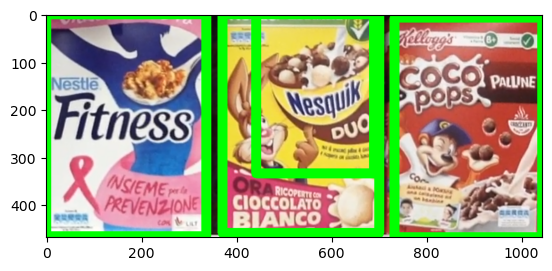

Product 0 - 1 instance/s found:
	Instance 1 position: (442, 0), width: 259px, height: 338px
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 0 instance/s found:
Product 24 - 1 instance/s found:
	Instance 1 position: (0, 0), width: 335px, height: 490px
Product 26 - 1 instance/s found:
	Instance 1 position: (371, 0), width: 336px, height: 491px
Product 25 - 1 instance/s found:
	Instance 1 position: (733, 7), width: 296px, height: 562px
________________________________________________________________________________



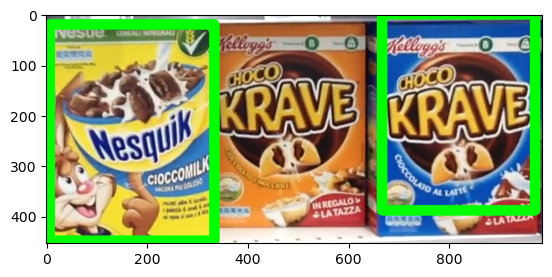

Product 0 - 1 instance/s found:
	Instance 1 position: (7, 20), width: 325px, height: 444px
Product 1 - 1 instance/s found:
	Instance 1 position: (667, 0), width: 301px, height: 412px
Product 11 - 0 instance/s found:
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 0 instance/s found:
________________________________________________________________________________



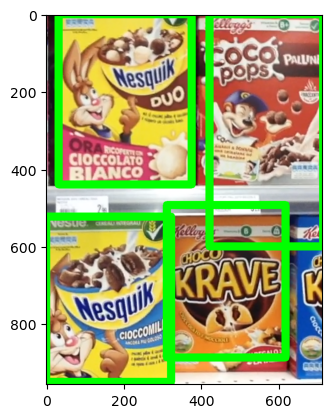

Product 0 - 1 instance/s found:
	Instance 1 position: (0, 523), width: 325px, height: 445px
Product 1 - 0 instance/s found:
Product 11 - 1 instance/s found:
	Instance 1 position: (311, 493), width: 299px, height: 400px
Product 19 - 0 instance/s found:
Product 24 - 0 instance/s found:
Product 26 - 1 instance/s found:
	Instance 1 position: (32, 0), width: 345px, height: 497px
Product 25 - 1 instance/s found:
	Instance 1 position: (421, 0), width: 286px, height: 567px
________________________________________________________________________________



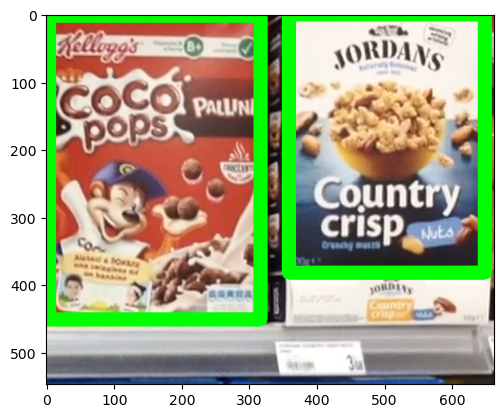

Product 0 - 0 instance/s found:
Product 1 - 0 instance/s found:
Product 11 - 0 instance/s found:
Product 19 - 1 instance/s found:
	Instance 1 position: (359, 0), width: 293px, height: 387px
Product 24 - 0 instance/s found:
Product 26 - 0 instance/s found:
Product 25 - 1 instance/s found:
	Instance 1 position: (4, 2), width: 319px, height: 445px
________________________________________________________________________________



In [32]:
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(final_scene_images_with_bb[j], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(e_results, j)

#  Step B - Multiple Object Detection


 Computation of the center belonging to the model image.
 Knowing the model image has a rectangular shape, the center coordinates of the cereal box can be taken by halfing the vertical and horizontal dimensions of the model image; So definig a reference system with origin the top-left corner of the model image considering the vertical direction represented by the x-axis and the horizontal one represented by the y-axis then the center G of each model will be found in the position (height/2, width/2).
 

In [33]:
#Definition of the function which find the model center and stores it in the dictionary "model_images_features"
def InstanceCenter(model_img,model_images_features, i, CENTER_INDEX=3):
    height, width, channels = model_img.shape
    v = int(height/2) # vertical coordinate of the image center
    h = int(width/2)  # horizontal position of the image center
    G = np.array([h, v]) # Defnition of the position center of the model
    if len( model_images_features[i])<=CENTER_INDEX:
        model_images_features[i].append(G) # Updating the model feature dictionary appending the information of the center
    else :
        #in the case G is already present in the model feature dictionary then update the G alreary there
        model_images_features[i][CENTER_INDEX] = G

Definition of the dictionary containing the informations of the scenes selected for this section:

In [34]:
scenes_to_test = [1, 2, 3, 4, 5]

# Dictionary that contains the image, all keypoints and descriptors for each easy scene image
m_scenes_images_features = {}

for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/m{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    m_scenes_images_features[i] = [scene_img, kp_scene, des_scene]
    # scene_img_visualization = cv2.drawKeypoints(scene_img,kp_e_scemes_images['1'],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(cv2.cvtColor(e_scenes_images_features[str(i)][0], cv2.COLOR_BGR2RGB))
    # plt.show()

Defining a function able to print out images that show up the location of the center and the position of each keypoints  :

In [35]:
#Function defined to print the image where it is specified the location of the keypoints and the center of the image 
def Print_Center_Keypoint(model_img, model_images_features, GoodMatches,Img_scale=1000):
    #Print the G point in a resized version of each model image
    #creating a resized image of the model image in order to print the results in an homogeneous way
            #getting image dimensions 
    height, width, channels = model_img.shape
            #defining the new dimensions of the image
    dim_ratio = width/height
    new_height = Img_scale
    new_width  = int(new_height*dim_ratio)
    new_dim = (new_width, new_height)
            #image resizing
    resized_img = cv2.resize(model_img, new_dim, interpolation = cv2.INTER_AREA) 
            #computing the ratio between the vertical and the horizontal dimensions resizing process
    height_ratio = new_height/height
    width_ratio = new_width/width
            #computing the G in the image resized
    g_x = int(model_images_features[i][CENTER_INDEX][0]*width_ratio)
    g_y = int(model_images_features[i][CENTER_INDEX][1]*height_ratio)

            #computing the Kp points in the image resized
    for m in GoodMatches:
                # getting the coordinates of the m-th keypoint in the i-th model
        Kp_x = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[0])
        Kp_y = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[1])
        kp_x = int(Kp_x*width_ratio)
        kp_y = int(Kp_y*height_ratio)
                #Draw a Line 
        cv2.line(resized_img,(g_x,g_y),(kp_x,kp_y),(0,0,0),10) 
                #Drawing a dot in the position of Kp
        cv2.circle(resized_img,(kp_x, kp_y), 10, (0,255,0),20)
            
        #Drawing a dot in the position of G
    cv2.circle(resized_img,(g_x, g_y), 10, (255,55,236),25)
        #Plotting the resized image
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.show()    
    print("Number of Key point found : ",len(GoodMatches))    

Computing now the vectors starting from the keypoitns of the model and pointing the center G of the image then we would be able to identify the distance and the directions of each keypoint position with respect to G.

In [ ]:
# This function create or update the model_images_features dictionary which contains all the relevant features of the 
# each model image, with a list containing all the voting vectors computed for each good match between the keypoints of 
# the model and the scene image


def VotingVectors(Good_Matches,model_images_features, i):
    # getting the coordinates of the center of the i-th model, G
    G_x = model_images_features[i][CENTER_INDEX][0]
    G_y = model_images_features[i][CENTER_INDEX][1]
        
    #Initializing the vector V 
    V = []
    
    for m in Good_Matches:
        # getting the coordinates of the m-th keypoint in the i-th model
        Kp_x = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[0])
        Kp_y = int(model_images_features[i][KEYPOINT_INDEX][m.queryIdx].pt[1])
            
        #defining the point V = Kp[m,i] - G[i] 
        vx = Kp_x - G_x
        vy = Kp_y - G_y
            
        #computing the slope of the direction aligning the center point G with the m-th keypoint
        #in the case V = (0,0) it means basically that the point G[i] and Kp[m,i] are coincident and so the slope will not exist;
        # Or anothe case where the slope does not exist is if the the G[i] and the Kp[m,i] are aligned in a vertical line;
        #In such a cases the slope variable can be considered as an array containing two informations, the fisrt information is the 
        #actual value of the slope, while the second information encloses if the slope exists or not (1,0 respectively)
        if (np.abs(vx) + np.abs(vy)) == 0 :
            slope = [0, 0]
        elif vy == 0 :
            slope = [1, 0]
        else:
            slope = [vx/vy, 1]
            
        #creating an array containing the V coordinates and the slope of the line 
        v = [vx, vy, slope]
        V.append(v)

    if len( model_images_features[i]) <= V_INDEX :
        # Updating the model feature dictionary appending the information of the vector V
        model_images_features[i].append(V) 
    else: 
        #in the case V is already present in the model feature dictionary then update the V alreary there
        model_images_features[i][V_INDEX] = V

    return V    

In [ ]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4

for j in scenes_to_test:
    for i in range(NUM_OF_MODELS):
        
        model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)
        
        #Find or update the center of the model image information collected in the model features dictionary
        InstanceCenter(model_img,model_images_features, i, CENTER_INDEX=3) 
        
        #Finding matches between the keypoints of the scene and the keypoints found in the model
        good = Matching(model_images_features[i][DESCRIPTOR_INDEX], m_scenes_images_features[j][DESCRIPTOR_INDEX])
                
        # Creating or Updating the model feature dictionary with the informations regarding the voting vectors
        V = VotingVectors(good,model_images_features, i)
        
        # Print the model images
        Print_Center_Keypoint(model_img, model_images_features, good,Img_scale=1000)

            
            

Building now an accumulator array in order to estimate the position of the center of each instance of the model in the scene :

In [ ]:
#function which is supposed to take a scene image and, provided the dimension of a cell of the accumulator array, 
#it sections graphically the image in order to visualize the accumulator array referred to the scene

def plot_Img_sectioned(img, k1, k2):
    H,W = img.shape[:2]
    for w in range(0,W,k1):
        #Draw a Vertical Line 
        cv2.line(img,(w,0),(w,H),(0,0,0),3) 
    for h in range(0,H,k2):
        #Draw an Horizontal Line 
        cv2.line(img,(0,h),(W,h),(0,0,0),3) 
        
    #Plotting the tabled image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()   

In [ ]:
def KeyPoints_Comparison(models_images_features,scenes_images_features, Good_Matches):
    model_kps_size = [] #list containing the size of each matched keypoint belonging to the model
    scene_kps_size = [] #list containing the size of each matched keypoint belonging to the scene
    ratio_of_sizes = [] #list containing the ratio between the sizes of the same keypoint found in the model and in the scene, representing the change in dimensions
    
    model_kps_angle = [] #list containing the angle of each matched keypoint belonging to the model
    scene_kps_angle = [] #list containing the angle of each matched keypoint belonging to the scene
    relative_angles = [] #list containing the angle between the model and the scene, representing rotation occuring between model and scene instance
    
    for o in Good_Matches:
             #Defining two vectors respectively containing the size of the keypoints belonging to the model and 
             #to the scene
        M_kp_size = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].size)
        S_kp_size = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].size)
        model_kps_size.append(M_kp_size)
        scene_kps_size.append(S_kp_size)
             #Defining two vectors respectively containing the angle of the keypoints belonging to the model and 
             #to the scene        
        M_kp_angle = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].angle)
        S_kp_angle = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].angle)
        model_kps_angle.append(M_kp_angle)
        scene_kps_angle.append(S_kp_angle)

             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        ratio_of_sizes.append(M_kp_size/S_kp_size)
        
             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        relative_angles.append(M_kp_angle-S_kp_angle)       

    #computation of the mean scale factor
    if len(ratio_of_sizes) : 
        Mean_Scale_Factor = (sum(ratio_of_sizes))/len(ratio_of_sizes)
    else: 
        # Mean_Scale_Factor = 0
        Mean_Scale_Factor = 3.5
    #computation of the mean relative angle
    if len(relative_angles) :
        Mean_Relative_Angle = (sum(relative_angles))/len(relative_angles)
    else: 
        Mean_Relative_Angle = 0
        
        
    return Mean_Scale_Factor, Mean_Relative_Angle

In [ ]:
def Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2, Scene_img, Model_img, 
                      models_images_features, scenes_images_features, Good_Matches, V, i, j, KEYPOINT_INDEX = 1):
    #Accumulator dimensions
    Acc_dim = (int(scenes_images_features[j][0].shape[0] / ACC_ARRAY_CELL_DIMENSION_2), 
               int(scenes_images_features[j][0].shape[1] / ACC_ARRAY_CELL_DIMENSION_1))
    Accumulator_Array_Points = {}
    #Accumulator array as a matrix of zeroes
    Accumulator_Array = np.zeros(Acc_dim)
    #print(Accumulator_Array.shape)
    #extracting all the keypoints of the scene resulting in good matches
    scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
        
        
        GS_x = int(Gx_scene/(ACC_ARRAY_CELL_DIMENSION_1))
        GS_y = int(Gy_scene/(ACC_ARRAY_CELL_DIMENSION_2))
        # print([Gx_scene, Gy_scene])
        if GS_x in range(Acc_dim[1]):
            if GS_y in range(Acc_dim[0]):
                # print([GS_y, GS_x])
                Accumulator_Array[GS_y,GS_x] += 1

                # save the scene points that fall into the current cell of the accumulator array, 
                if not (GS_y,GS_x, 'S') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                '''
                # save the model points corresponding to the scene point that fell into the current
                # cell of the accumulator array, so to be able to compute then the homography
                if not (GS_y,GS_x, 'M') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')].append(np.float32(models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')].append(np.float32(models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))

                # save also the list of indexes of good matches to use to be able to draw the bounding box later
                if not (GS_y,GS_x, 'L') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')].append(l)
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')].append(l)
                '''
        
    #print(Accumulator_Array)
    
    return Accumulator_Array, G_scene, Accumulator_Array_Points

Function that estimates the centers in the scene of the models

In [ ]:
def center_estimation(models_images_features, scenes_images_features, Good_Matches, V, j):
    #extracting all the keypoints of the scene resulting in good matches
    scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
    
    return G_scene, r

In [ ]:
# function that merges adjacent bounding boxes that overlap between each other       
def merge_overlapping_bounding_boxes(corners_of_bounding_boxes, DISTANCE_BOUNDING_BOXES_TRESHOLD=200):
    # top left and bottom right corners of the final bounding boxes
    final_corners_of_bounding_boxes = []
    
    for index_1, [top_left_corner, bottom_right_corner] in enumerate(corners_of_bounding_boxes):
            # add first couple of top left and bottom right corners of the final bounding boxes
            if len(final_corners_of_bounding_boxes) == 0:
                final_corners_of_bounding_boxes.append([ (int(top_left_corner[0]), int(top_left_corner[1])), 
                                                            (int(bottom_right_corner[0]), int(bottom_right_corner[1]))])
            
            
            for index_2, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
                # if a corner is already in the final corners then I don't add it
                if top_left_corner == fin_top_left_corner and bottom_right_corner == fin_bottom_right_corner:
                    break
                # if a corner is near (below DISTANCE_BOUNDING_BOXES_TRESHOLD) a final corner, then I mean the two into a
                # single one
                if ( distance_2_points(top_left_corner, fin_top_left_corner) < DISTANCE_BOUNDING_BOXES_TRESHOLD and 
                distance_2_points(fin_bottom_right_corner, bottom_right_corner) < DISTANCE_BOUNDING_BOXES_TRESHOLD ) :
                    
                    sum_top_left = tuple(map(operator.add, top_left_corner, fin_top_left_corner))
                    sum_bottom_right = tuple(map(operator.add, bottom_right_corner ,fin_bottom_right_corner))
                    mean_top_left = (sum_top_left[0]/2, sum_top_left[1]/2)
                    mean_bottom_right = (sum_bottom_right[0]/2, sum_bottom_right[1]/2)
                    print('mean_top_left', mean_top_left)
                    final_corners_of_bounding_boxes[index_2] = [ (int(mean_top_left[0]), int(mean_top_left[1])), 
                                                            (int(mean_bottom_right[0]), int(mean_bottom_right[1]))]
        
                    break
                # if my corner is'n near any final corner then I add it to the final corners
                if index_2 == len(final_corners_of_bounding_boxes) - 1:
                    final_corners_of_bounding_boxes.append([ (int(top_left_corner[0]), int(top_left_corner[1])), 
                                                            (int(bottom_right_corner[0]), int(bottom_right_corner[1]))])
    return final_corners_of_bounding_boxes

In [ ]:
# PROVA PRIMA COLORE E POI ;ERGE

import operator

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = [0, 1, 11, 19, 24, 25, 26]
scenes_to_test = [1,2,3,4,5]

m_results = {}

m_final_scene_images_with_bb = {}

# Parameters to tune

#dimension of a single cell of the accumulator array
ACC_ARRAY_CELL_DIMENSION_1 = 120
ACC_ARRAY_CELL_DIMENSION_2 = 120
# minimum number of votes to consider G as a valid point
MIN_VOTES = 1
#treshold passed to the Matching function
MATCHING_TRESHOLD = 0.45
# distance to merge two bounding boxes
DISTANCE_BOUNDING_BOXES_TRESHOLD = 200


COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 82

N_BINS_ON_WIDTH = 3

M_BINS_ON_HEIGHT = 4


#print(m_scenes_images_features[1][0].shape[:2])
#plt.imshow(cv2.cvtColor(m_scenes_images_features[1][0], cv2.COLOR_BGR2RGB))
#plt.show()

for j in scenes_to_test:
    m_final_scene_images_with_bb[j] = np.copy(m_scenes_images_features[j][IMAGE_INDEX])
    m_results[j] = {}
    for i in models_to_test:
        scene_img = cv2.imread('./scenes/m{}.png'.format(j), cv2.COLOR_BGR2RGB)
        model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)

        print('_' * 80 + '\n')
        print('Finding model {} in scene {}'.format(i,j))

        m_results[j][i] = {}
        m_results[j][i]['count'] = 0
        
        # Special move
        for special_move in [1,2]:
            #Finding matches between the keypoints of the scene and the keypoints found in the model
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], m_scenes_images_features[j][DESCRIPTOR_INDEX], 
                            Treshold=MATCHING_TRESHOLD)

        
        V = VotingVectors(good,model_images_features, i)

        ACC, G_scene, Accumulator_Array_Points = Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1,
                                                                      ACC_ARRAY_CELL_DIMENSION_2,
                                                                      scene_img, 
                                                                      model_img,
                                                                      model_images_features, 
                                                                      m_scenes_images_features, 
                                                                      good, 
                                                                      V, 
                                                                      i, j)
        for g in G_scene :
            #Drawing a dot in the position of G
            #print(g)
            #if np.max(ACC)>=20:
            cv2.circle(scene_img,(int(g[0]), int(g[1])), 10, (255,55,236),25)

        # List of indexes of highlighted cells (list of cells that have a num votes >= MIN_VOTES)
        highlighted_cells_of_current_model_in_current_scene = []

        print('List of highlighted cells:')
        # print(ACC.shape[0], ACC.shape[1])
        for t in range(ACC.shape[0]):
            for w in range(ACC.shape[1]):
                #print(t,w)
                # If a cell of the accumulator array has more than MIN_VOTES than it means that the model has been found
                if ACC[t,w] >= MIN_VOTES:


                    print('  - Num votes: {} in cell {} '.format(ACC[t,w], (t,w)))
                    # print('Max in Accumulator Array : ', np.max(ACC))
                    highlighted_cells_of_current_model_in_current_scene.append([t, w])
                    #print(Accumulator_Array_Points[(t, w, 'S')])


        # print(highlighted_cells_of_current_model_in_current_scene)
                
        #V = VotingVectors(good, model_images_features, i)
        # estimated centers of the bounding boxes
        G_scenes, r = center_estimation(model_images_features, m_scenes_images_features, good, V, j)

        print('r: ', r)
        # getting the scaled height and width of the model in the scene
        model_height_in_the_scene = model_images_features[i][IMAGE_INDEX].shape[0] / r                                               
        model_width_in_the_scene = model_images_features[i][IMAGE_INDEX].shape[1] / r

        m_scene_img_copy = np.copy(m_scenes_images_features[j][IMAGE_INDEX])

        corners_of_bounding_boxes = []

        for c in highlighted_cells_of_current_model_in_current_scene :
            # Compute G (the center of the cereal box in the scene) as the mean of points that fall 
            # into the higlighted cell
            G_mean = np.mean(Accumulator_Array_Points[(c[0], c[1], 'S')], axis=0)
            cv2.circle(scene_img,(int(G_mean[0]), int(G_mean[1])), 20, (0,0,0),25)

            cv2.rectangle(scene_img,(c[1]*ACC_ARRAY_CELL_DIMENSION_1,c[0]*ACC_ARRAY_CELL_DIMENSION_2),
                          ((c[1]+1)*ACC_ARRAY_CELL_DIMENSION_1,(c[0]+1)*ACC_ARRAY_CELL_DIMENSION_2),(0,255,0),10)



            top_left_corner_of_bounding_box = ( int(int(G_mean[0]) - (model_width_in_the_scene / 2) ), 
                                            int(int(G_mean[1]) - (model_height_in_the_scene / 2) ) )
            bottom_right_corner_of_buonding_box = ( int(int(G_mean[0]) + (model_width_in_the_scene / 2) ), 
                                            int(int(G_mean[1]) + (model_height_in_the_scene / 2) ) )


            top_right_corner_of_bounding_box = (bottom_right_corner_of_buonding_box[0], top_left_corner_of_bounding_box[1])

            corners_of_bounding_boxes.append([top_left_corner_of_bounding_box, bottom_right_corner_of_buonding_box]) 

            scene_img_with_bounding_boxes = cv2.rectangle(m_scene_img_copy,
                                          top_left_corner_of_bounding_box,
                                          bottom_right_corner_of_buonding_box,
                                          (0,255,0), 10)

        

        # solve exceeding dimensions of bounding boxes in the scene
        final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(
            corners_of_bounding_boxes, m_scenes_images_features)

        # solve color problem
        #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem(final_corners_of_bounding_boxes_without_exceeding_dimensions, m_scenes_images_features, j)

        # solve color problem with bins

        final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
            final_corners_of_bounding_boxes_without_exceeding_dimensions, 
            m_scenes_images_features, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
            COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES)
        
        # merge overlapping bounding boxes
        final_corners_of_bounding_boxes = merge_overlapping_bounding_boxes(final_corners_of_bounding_boxes_after_color_problem, 
                                                                           DISTANCE_BOUNDING_BOXES_TRESHOLD)


        print('Model {}'.format(i))
        #plotting the model image
        plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB))
        plt.show()


        #plotting the scene image
        plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
        plt.show()

        # plotting every cell of the accumulator array on the scene image
        scene_img_sctioned = np.copy(scene_img)
        plot_Img_sectioned(scene_img_sctioned, ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2)
        print(ACC[ACC != 0])

        # if I don't find any cell that has the min num of votes, then I don't print the bounding box
        if(len(highlighted_cells_of_current_model_in_current_scene) > 0):
            print('  - Found {} instances of model {} in scene {}'.format(len(highlighted_cells_of_current_model_in_current_scene),i,j))
            # plotting the bounding box
            plt.imshow(cv2.cvtColor(scene_img_with_bounding_boxes, cv2.COLOR_BGR2RGB))
            plt.show()
        else:
            print('  - Model {} NOT found in the scene {}'.format(i,j))

        # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
        plot_final_bounding_boxes(None, final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                  m_scenes_images_features, j)

        print('AFTER COLOR CORRECTION:')
        # plot image with final bounding boxes, after color problem
        m_img_bb = plot_final_bounding_boxes(m_final_scene_images_with_bb[j], 
                                             final_corners_of_bounding_boxes, 
                                             m_scenes_images_features, j)

        if m_img_bb is not None:
            m_final_scene_images_with_bb[j] = m_img_bb

        m_results[j][i]['count'] += len(final_corners_of_bounding_boxes)


In [ ]:
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(m_final_scene_images_with_bb[j], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(m_results, j)

In [ ]:
def solve_color_problem_with_difference_N_x_M_bins(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                   difficulty_scenes_images_features, 
                                                   i, j, N=3, M=4, 
                                                   COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 50, 
                                                   MAX_NUM_OF_NO_GOOD_CELLS = 5):
    final_corners_of_bounding_boxes_after_color_problem = []
    
    model_img = np.copy(model_images_features[i][IMAGE_INDEX])
    
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
        
        # model probably found in the scene
        model_found_in_the_scene = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                   fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        # define new dimension that the model image should now have, 
        # which is the dimension of the probably found model in the scene 
        new_dim = (model_found_in_the_scene.shape[1], model_found_in_the_scene.shape[0])
        
        # model image resizing
        resized_model_img = cv2.resize(model_img, new_dim, interpolation = cv2.INTER_AREA)
        
        # ValueError: operands could not be broadcast together with shapes (63,85,3) (85,63,3) 

        resized_model_img = resized_model_img.reshape(model_found_in_the_scene.shape[0], model_found_in_the_scene.shape[1],
                                                     model_found_in_the_scene.shape[2])
        
        # perform difference of intensities between the scaled model image and the probably found model in the scene image 
        diff_image = resized_model_img -  model_found_in_the_scene
        
        # plot the resized model image
        plt.imshow(cv2.cvtColor(resized_model_img, cv2.COLOR_BGR2RGB))
        plt.show()
        
        # plot the probably model found in the scene
        plt.imshow(cv2.cvtColor(model_found_in_the_scene, cv2.COLOR_BGR2RGB))
        plt.show() 
        
        
        
        # divide the image containing the difference of intensities into N x M bins
        means_bins_diff_img = split_image_into_N_x_M_bins_with_intensity_means(diff_image, 
                                                                               n_bins_width = N, 
                                                                               n_bins_heigth = M)
        
        if not means_bins_diff_img:
            return []
    
        good = True
        num_of_No_good = 0
        
        # cycle the model dictionary and get the means by getting the keys of the scene dictionary
        for k, v in means_bins_diff_img.items():
            means_k_diff = means_bins_diff_img.get(k)
            
            # PRINT ALL THE DIFFERENCES
            print('Bin ({}, {}):'.format(k[0], k[1]))
            print('  - diff_r: ', means_k_diff[0])
            print('  - diff_g: ', means_k_diff[1])
            print('  - diff_b: ', means_k_diff[2])
            
            if means_k_diff[0] >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                means_k_diff[1] >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                means_k_diff[2] >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
                print('___________________NO GOOD___________________')
                num_of_No_good += 1
               
                good = False
        print('Num of No Good Bins: {}'.format(num_of_No_good))
            
        if num_of_No_good <= MAX_NUM_OF_NO_GOOD_CELLS: #good:
            final_corners_of_bounding_boxes_after_color_problem.append(
                [ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                 (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [ ]:
def KeyPoints_Comparison(models_images_features,scenes_images_features, Good_Matches):
    model_kps_size = [] #list containing the size of each matched keypoint belonging to the model
    scene_kps_size = [] #list containing the size of each matched keypoint belonging to the scene
    ratio_of_sizes = [] #list containing the ratio between the sizes of the same keypoint found in the model and in the scene, representing the change in dimensions
    
    model_kps_angle = [] #list containing the angle of each matched keypoint belonging to the model
    scene_kps_angle = [] #list containing the angle of each matched keypoint belonging to the scene
    relative_angles = [] #list containing the angle between the model and the scene, representing rotation occuring between model and scene instance
    
    for o in Good_Matches:
             #Defining two vectors respectively containing the size of the keypoints belonging to the model and 
             #to the scene
        M_kp_size = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].size)
        S_kp_size = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].size)
        model_kps_size.append(M_kp_size)
        scene_kps_size.append(S_kp_size)
             #Defining two vectors respectively containing the angle of the keypoints belonging to the model and 
             #to the scene        
        M_kp_angle = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].angle)
        S_kp_angle = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].angle)
        model_kps_angle.append(M_kp_angle)
        scene_kps_angle.append(S_kp_angle)

             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        ratio_of_sizes.append(M_kp_size/S_kp_size)
        
             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        relative_angles.append(M_kp_angle-S_kp_angle)       

    #computation of the mean scale factor
    if len(ratio_of_sizes) : 
        Mean_Scale_Factor = (sum(ratio_of_sizes))/len(ratio_of_sizes)
    else: 
        # Mean_Scale_Factor = 0
        Mean_Scale_Factor = 17.8#3.5#20#15#17.7
    #computation of the mean relative angle
    if len(relative_angles) :
        Mean_Relative_Angle = (sum(relative_angles))/len(relative_angles)
    else: 
        Mean_Relative_Angle = 0
        
        
    return Mean_Scale_Factor, Mean_Relative_Angle

In [ ]:
# dictionary for hard scene features
h_scenes_images_features = {}
scenes_to_test = [1,2,3,4,5,6]


# add features for each hard scene image
for i in scenes_to_test:
    scene_img = cv2.imread('./scenes/h{}.jpg'.format(i), cv2.COLOR_BGR2GRAY) #cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(scene_img)
    kp_scene, des_scene = sift.compute(scene_img, kp_scene)
    h_scenes_images_features[i] = [scene_img, kp_scene, des_scene]

# indexes of the dictionary
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
TRESHOLD_INDEX = 5

# models to test in stepC
models_to_test = list(range(1, 27))

### Divide a scene image into shelves images

In [ ]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    plt.show()

In [ ]:
def get_horizontal_lines_of_image(scene_img_index, difficulty_scenes_images_features):
    # Load the image
    src = np.copy(difficulty_scenes_images_features[scene_img_index][IMAGE_INDEX])
    plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB));
    plt.show()
    # [gray]
    # Transform source image to gray if it is not already


    if len(src.shape) != 2:
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    else:
        gray = src
    
    # Show gray image
    #show(gray)

    # [bin]
    # Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
    gray = cv2.bitwise_not(gray)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                cv2.THRESH_BINARY, 15, -2)
    # Show binary image
    #show(bw)

    # Create the images that will use to extract the horizontal and vertical lines
    horizontal = np.copy(bw)
    # [horiz]
    # Specify size on horizontal axis
    cols = horizontal.shape[1]
    horizontal_size = cols // 20

    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 2))

    # Apply morphology operations
    horizontal = cv2.erode(horizontal, horizontalStructure)
    horizontal = cv2.erode(horizontal, horizontalStructure)

    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)


    # Show extracted horizontal lines
    show(horizontal)
    return horizontal

In [ ]:
def set_height_coord_of_shelves_in_scene_img(height_coord_of_shelves_in_all_scenes, horizontal_features_img):
    
    horiz_height = horizontal_features_img.shape[0]
    horiz_width = horizontal_features_img.shape[1]

    # image with horizontal features in which I will show the shelves in red
    horizontal_with_shelves_lines = np.copy(cv2.cvtColor(horizontal_features_img, cv2.COLOR_GRAY2RGB))
    # scene image in which I will show the shelves in red
    scene_img_with_shelves_lines = np.copy(h_scenes_images_features[j][IMAGE_INDEX])

    height_coord_of_shelves_in_all_scenes.setdefault(j, []).append(0)

    # cycle the pixels on the height of the image, with width = WIDTH_MEASURE 
    for height_coord in range(horiz_height):
        # I checked that in the horizontal image there are intensities which are only = 0 or = 255
        # if there is a white pixel in the along width = 100, and if the previous found pixel was black
        # then record the position of a shelf
        if( horizontal_features_img[height_coord, WIDTH_MEASURE] == 255 
           and horizontal_features_img[height_coord - 1, WIDTH_MEASURE] == 0 ):
            print(height_coord, WIDTH_MEASURE)
            # add the height coord of the found shelf in the list of the current scene, which is contained in the dictionary
            height_coord_of_shelves_in_all_scenes.setdefault(j, []).append(height_coord)
            horizontal_with_shelves_lines = cv2.line(horizontal_with_shelves_lines, (0, height_coord), 
                                                     (horiz_width, height_coord), (0,0,255), 3)
            
            scene_img_with_shelves_lines = cv2.line(scene_img_with_shelves_lines, (0, height_coord), 
                                                     (horiz_width, height_coord), (0,0,255), 3)

    show(horizontal_with_shelves_lines)
    show(scene_img_with_shelves_lines)
    

In [ ]:
def get_shelves_images_from_scene_img(scene_img_index, scenes_shelves_features,
                                      height_coord_of_shelves_in_all_scenes, difficulty_scenes_images_features):
    
    MIN_HEIGHT_THAT_A_SHELF_SHOULD_HAVE = 20
    
    height_of_scene_img, width_of_scene_img = difficulty_scenes_images_features[scene_img_index][IMAGE_INDEX].shape[:2]
    
    for i, height_coord in enumerate(height_coord_of_shelves_in_all_scenes[scene_img_index]):        
        if i == 0:
            scenes_shelves_features[scene_img_index] = {}
            
        # If Itake the last shelf, then I have to take the portion of image starting from its height coord to
        # the height of the image
        if i == len(height_coord_of_shelves_in_all_scenes[scene_img_index]) - 1:
            # I consider a shelf good only if its height is >= of a min treshold
            if height_of_scene_img - height_coord >= MIN_HEIGHT_THAT_A_SHELF_SHOULD_HAVE:
                scenes_shelves_features[scene_img_index][i] = \
                    [ difficulty_scenes_images_features[scene_img_index][IMAGE_INDEX][height_coord:height_of_scene_img]\
                    [0:width_of_scene_img] ]
        # else I take the portion of the image from its height coord to the next height coord
        else:
            next_height_coord = height_coord_of_shelves_in_all_scenes[scene_img_index][i+1]

            if next_height_coord - height_coord >= MIN_HEIGHT_THAT_A_SHELF_SHOULD_HAVE:
                scenes_shelves_features[scene_img_index][i] = \
                    [ difficulty_scenes_images_features[scene_img_index][IMAGE_INDEX][height_coord:next_height_coord]\
                    [0:width_of_scene_img] ]
            

In [ ]:
WIDTH_MEASURE = 100

# dictionary that will contain the height coordinate of every shelf in each scene image
height_coord_of_shelves_in_all_scenes = {}
scenes_to_test = [1,2,3,4,5]

scenes_shelves_features = {}


for j in scenes_to_test:
    print( ('_' * 40) + 'scene {}'.format(j) + ('_' * 40) + '\n')
    
    horizontal_features_img = get_horizontal_lines_of_image(j, h_scenes_images_features)
    
    set_height_coord_of_shelves_in_scene_img(height_coord_of_shelves_in_all_scenes, horizontal_features_img)
    
    get_shelves_images_from_scene_img(j, scenes_shelves_features,
                                      height_coord_of_shelves_in_all_scenes, h_scenes_images_features)



In [ ]:
for scene_index, img_shelves_of_scene in scenes_shelves_features.items():
    print(('_' * 40) + 'scene {}'.format(scene_index) + ('_' * 40))
    for shelf_index, shelf_features in img_shelves_of_scene.items():
        #doubled_shelf_image = cv2.resize(shelf_features[IMAGE_INDEX], (shelf_features[IMAGE_INDEX].shape[1] * 2, 
        #                                         shelf_features[IMAGE_INDEX].shape[0] * 2), 
        #           interpolation = cv2.INTER_AREA)
        # print(shelf_features[IMAGE_INDEX].shape)
        # save the image of a single shelf in the structure
        print('shelf image:')
        show(shelf_features[IMAGE_INDEX])
        #print('doubled shelf image')
        #show(doubled_shelf_image)
        # compute keypoints and descriptors of the single shelf and save them in the structure too
        kp_shelf = sift.detect(shelf_features[IMAGE_INDEX])
        kp_shelf, des_shelf = sift.compute(shelf_features[IMAGE_INDEX], kp_shelf)
        img_shelves_of_scene[shelf_index] = [shelf_features[IMAGE_INDEX], kp_shelf, des_shelf]    

In [ ]:
def KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches, shelf=False):
    model_kps_size = [] #list containing the size of each matched keypoint belonging to the model
    scene_kps_size = [] #list containing the size of each matched keypoint belonging to the scene
    ratio_of_sizes = [] #list containing the ratio between the sizes of the same keypoint found in the model and in the scene, representing the change in dimensions
    
    model_kps_angle = [] #list containing the angle of each matched keypoint belonging to the model
    scene_kps_angle = [] #list containing the angle of each matched keypoint belonging to the scene
    relative_angles = [] #list containing the angle between the model and the scene, representing rotation occuring between model and scene instance
    
    for o in Good_Matches:
             #Defining two vectors respectively containing the size of the keypoints belonging to the model and 
             #to the scene
        M_kp_size = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].size)
        if shelf:
            S_kp_size = np.float32(scenes_images_features[KEYPOINT_INDEX][o.trainIdx].size)
        else:
            S_kp_size = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].size)
        model_kps_size.append(M_kp_size)
        scene_kps_size.append(S_kp_size)
             #Defining two vectors respectively containing the angle of the keypoints belonging to the model and 
             #to the scene        
        M_kp_angle = np.float32(models_images_features[i][KEYPOINT_INDEX][o.queryIdx].angle)
        if shelf:
        	S_kp_angle = np.float32(scenes_images_features[KEYPOINT_INDEX][o.trainIdx].angle)
        else:
            S_kp_angle = np.float32(scenes_images_features[j][KEYPOINT_INDEX][o.trainIdx].angle)
        model_kps_angle.append(M_kp_angle)
        scene_kps_angle.append(S_kp_angle)

             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        ratio_of_sizes.append(M_kp_size/S_kp_size)
        
             #defining the change in dimensions between the keypoints of the model compared to the same ones found 
             #in the scene side
        relative_angles.append(M_kp_angle-S_kp_angle)       

    #computation of the mean scale factor
    if len(ratio_of_sizes) : 
        Mean_Scale_Factor = (sum(ratio_of_sizes))/len(ratio_of_sizes)
        print('bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb {}'.format(Mean_Scale_Factor))
    else: 
        # Mean_Scale_Factor = 0
        Mean_Scale_Factor = 16.7
        print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa {}'.format(Mean_Scale_Factor))
    #computation of the mean relative angle
    if len(relative_angles) :
        Mean_Relative_Angle = (sum(relative_angles))/len(relative_angles)
    else: 
        Mean_Relative_Angle = 0
        
        
    return Mean_Scale_Factor, Mean_Relative_Angle

In [ ]:
def Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2, Scene_img, Model_img, 
                      models_images_features, scenes_images_features, Good_Matches, V, i, j, shelf=False, KEYPOINT_INDEX = 1):
    #Accumulator dimensions
    if shelf:
    	Acc_dim = (int(scenes_images_features[0].shape[0] / ACC_ARRAY_CELL_DIMENSION_2), 
	               int(scenes_images_features[0].shape[1] / ACC_ARRAY_CELL_DIMENSION_1))
    else:
	    Acc_dim = (int(scenes_images_features[j][0].shape[0] / ACC_ARRAY_CELL_DIMENSION_2), 
	               int(scenes_images_features[j][0].shape[1] / ACC_ARRAY_CELL_DIMENSION_1))
    Accumulator_Array_Points = {}
    #Accumulator array as a matrix of zeroes
    Accumulator_Array = np.zeros(Acc_dim)
    #print(Accumulator_Array.shape)
    #extracting all the keypoints of the scene resulting in good matches
    if shelf:
    	scene_pts = np.float32([scenes_images_features[KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    else:
    	scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches, shelf)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
        
        
        GS_x = int(Gx_scene/(ACC_ARRAY_CELL_DIMENSION_1))
        GS_y = int(Gy_scene/(ACC_ARRAY_CELL_DIMENSION_2))
        # print([Gx_scene, Gy_scene])
        if GS_x in range(Acc_dim[1]):
            if GS_y in range(Acc_dim[0]):
                # print([GS_y, GS_x])
                Accumulator_Array[GS_y,GS_x] += 1

                # save the scene points that fall into the current cell of the accumulator array, 
                if not (GS_y,GS_x, 'S') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'S')].append((Gx_scene, Gy_scene))
                '''
                # save the model points corresponding to the scene point that fell into the current
                # cell of the accumulator array, so to be able to compute then the homography
                if not (GS_y,GS_x, 'M') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')].append(np.float32(models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'M')].append(np.float32(models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))

                # save also the list of indexes of good matches to use to be able to draw the bounding box later
                if not (GS_y,GS_x, 'L') in Accumulator_Array_Points:
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')] = []
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')].append(l)
                else:
                    Accumulator_Array_Points[(GS_y, GS_x, 'L')].append(l)
                '''
        
    #print(Accumulator_Array)
    
    return Accumulator_Array, G_scene, Accumulator_Array_Points

In [ ]:
def center_estimation(models_images_features, scenes_images_features, Good_Matches, V, j, shelf=False):
    #extracting all the keypoints of the scene resulting in good matches
    if shelf:
        scene_pts = np.float32([scenes_images_features[KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    else:
        scene_pts = np.float32([scenes_images_features[j][KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #computing the mean scale factor and the mean relative angle occuring between the model and its instances on the scene
    r , alpha = KeyPoints_Comparison(models_images_features, scenes_images_features, Good_Matches, shelf)
    
    #defining the list wich will contain all the G estimation
    G_scene = []
    for l in range(len(Good_Matches)):
        # print((models_images_features[i][KEYPOINT_INDEX][Good_Matches[l].queryIdx].pt))
        #rescaling of the voting vectors
        Vx_scene = V[l][0] / r
        Vy_scene = V[l][1] / r
        #computing the estimate position of the center pointed by the l-th voting vector rescaled starting from the l-th keypoint
        Gx_scene = scene_pts[l][0][0] - Vx_scene
        Gy_scene = scene_pts[l][0][1] - Vy_scene

        #collecting the Center estimation in a list 
        G_scene.append([Gx_scene, Gy_scene])
    
    return G_scene, r

In [ ]:
# function that solves exceeding dimensions of bounding_boxes in scene
def solve_exceeding_dimensions_of_bounding_boxes_in_scene(final_corners_of_bounding_boxes, 
                                                          difficulty_scenes_images_features,
                                                          bounding_box_confidence,
                                                          bb_conf_after_exceeding_dim,
                                                          shelf=False):
    final_corners_of_bounding_boxes_without_exceeding_dimensions = []
    # adjust bounding boxes that go out the dimensions of the scene image
    if shelf:
        scene_height = difficulty_scenes_images_features[IMAGE_INDEX].shape[0]
        scene_width = difficulty_scenes_images_features[IMAGE_INDEX].shape[1]
    else:
        scene_height = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[0]
        scene_width = difficulty_scenes_images_features[j][IMAGE_INDEX].shape[1]

    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
        
        old_top_left_corner = fin_top_left_corner
        old_bottom_right_corner = fin_bottom_right_corner
        
        fin_top_left_corner = list(fin_top_left_corner)
        fin_bottom_right_corner = list(fin_bottom_right_corner)
        
        
        # top left corner that goes out on the left of the scene image
        if fin_top_left_corner[0] < 0:
            fin_top_left_corner[0] = 0
        # bottom right corner that goes out on the left of the scene image
        if fin_bottom_right_corner[0] < 0:
            fin_bottom_right_corner[0] = 0
        # top left corner that goes out on the right of the scene image
        if fin_top_left_corner[0] > scene_width:
            fin_top_left_corner[0] = scene_width
        # bottom right corner that goes out on the right of the scene image
        if fin_bottom_right_corner[0] > scene_width:
            fin_bottom_right_corner[0] = scene_width
        # top left corner that goes out on the top of the scene image
        if fin_top_left_corner[1] < 0:
            fin_top_left_corner[1] = 0
        # bottom right corner that goes out on the top of the scene image
        if fin_bottom_right_corner[1] < 0:
            fin_bottom_right_corner[1] = 0  
        # top left corner that goes out on the bottom of the scene image
        if fin_top_left_corner[1] > scene_height:
            fin_top_left_corner[1] = scene_height
        # bottom right corner that goes out on the bottom of the scene image
        if fin_bottom_right_corner[1] > scene_height:
            fin_bottom_right_corner[1] = scene_height

        fin_top_left_corner = tuple(fin_top_left_corner)
        fin_bottom_right_corner = tuple(fin_bottom_right_corner)
        final_corners_of_bounding_boxes_without_exceeding_dimensions.append([ (int(fin_top_left_corner[0]), 
                                                                               int(fin_top_left_corner[1])), 
                                                                             (int(fin_bottom_right_corner[0]), 
                                                                              int(fin_bottom_right_corner[1]))])
        # keep track of min_votes confidence after solving exceeding dimensions
        bb_conf_after_exceeding_dim[ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                    (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1])) ] = \
                                    bounding_box_confidence[ (old_top_left_corner, old_bottom_right_corner) ]
        
    return final_corners_of_bounding_boxes_without_exceeding_dimensions

In [ ]:
def solve_color_problem_with_N_x_M_bins(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                    difficulty_scenes_images_features, bb_conf_after_exceeding_dim,
                                    bb_conf_after_color_solver,
                                    i, j, N=3, M=4, 
                                    COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=50, 
                                    MAX_NUM_OF_NO_GOOD_CELLS = 5,
                                    shelf=False):
    final_corners_of_bounding_boxes_after_color_problem = []
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
    
        model_img = model_images_features[i][IMAGE_INDEX]
        # smooth
        blur_model_img = model_img #cv2.GaussianBlur(model_img,(45,45),0) #(45,45)
        
        means_bins_model_img = split_image_into_N_x_M_bins_with_intensity_means(
            blur_model_img, 
            N, M)
        
        
        
        print(fin_top_left_corner[1], fin_top_left_corner[0], fin_bottom_right_corner[1], fin_bottom_right_corner[0])
        
        if shelf:
            means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity_means(
                difficulty_scenes_images_features[IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
                N, M)
        else:
            means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity_means(
                difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
                N, M)
    
        if not means_bins_scene_img or not means_bins_scene_img:
            return []
    
        good = True
        num_of_No_good = 0

        
        # cycle the model dictionary and get the diff of the means by getting the keys of the scene dictionary
        for k, v in means_bins_model_img.items():
            
            # do not consider all bins that are on the top and on the bottom
            if k[0] != 0 and k[0] != N:
            
                print('CHIAVE')
                print(k[0], k[1])
                means_k_scene = means_bins_scene_img.get(k)
                # I consider a bounding box as good if and only if all the difference of the intiensities from the 
                # bins of the model, in all 3 channels, are below a certain treshold
                diff_r = np.absolute(v[0] - means_k_scene[0])
                diff_g = np.absolute(v[1] - means_k_scene[1])
                diff_b = np.absolute(v[2] - means_k_scene[2])

                print('Bin ({}, {}):'.format(k[0], k[1]))
                print('  - diff_r: ', diff_r)
                print('  - diff_g: ', diff_g)
                print('  - diff_b: ', diff_b)


                if diff_r >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or diff_g >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                    diff_b >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
                    print('___________________NO GOOD___________________')
                    good = False
                    num_of_No_good += 1
        
        
        if  num_of_No_good <= MAX_NUM_OF_NO_GOOD_CELLS: #good:
            final_corners_of_bounding_boxes_after_color_problem.append([ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                                        (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
            # add color bins solver confidence
            color_conf = (1 - (num_of_No_good / MAX_NUM_OF_NO_GOOD_CELLS)) 
            bb_conf_after_color_solver[(int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                       (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))] = \
                                        bb_conf_after_exceeding_dim[(fin_top_left_corner, fin_bottom_right_corner)]
            bb_conf_after_color_solver[(int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                       (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))].append(color_conf)
                                            

    return final_corners_of_bounding_boxes_after_color_problem

In [ ]:
def solve_color_problem_with_difference_N_x_M_bins(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                   difficulty_scenes_images_features, 
                                                   i, j, N=3, M=4, 
                                                   COLOR_DIFF_IN_SINGLE_CHANNEL_TRES = 50, 
                                                   MAX_NUM_OF_NO_GOOD_CELLS = 5, shelf=False):
    final_corners_of_bounding_boxes_after_color_problem = []
    
    model_img = np.copy(model_images_features[i][IMAGE_INDEX])
    
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
        
        # model probably found in the scene
        if shelf:
            model_found_in_the_scene = np.copy(difficulty_scenes_images_features[IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        else:
            model_found_in_the_scene = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        # define new dimension that the model image should now have, 
        # which is the dimension of the probably found model in the scene 
        new_dim = (model_found_in_the_scene.shape[1], model_found_in_the_scene.shape[0])
        
        # model image resizing
        resized_model_img = cv2.resize(model_img, new_dim, interpolation = cv2.INTER_AREA)
        
        # ValueError: operands could not be broadcast together with shapes (63,85,3) (85,63,3) 

        resized_model_img = resized_model_img.reshape(model_found_in_the_scene.shape[0], model_found_in_the_scene.shape[1],
                                                     model_found_in_the_scene.shape[2])
        
        # perform difference of intensities between the scaled model image and the probably found model in the scene image 
        diff_image = resized_model_img -  model_found_in_the_scene
        
        # plot the resized model image
        plt.imshow(cv2.cvtColor(resized_model_img, cv2.COLOR_BGR2RGB))
        plt.show()
        
        # plot the probably model found in the scene
        plt.imshow(cv2.cvtColor(model_found_in_the_scene, cv2.COLOR_BGR2RGB))
        plt.show() 
        
        
        
        # divide the image containing the difference of intensities into N x M bins
        means_bins_diff_img = split_image_into_N_x_M_bins_with_intensity_means(diff_image, 
                                                                               n_bins_width = N, 
                                                                               n_bins_heigth = M)
        
        if not means_bins_diff_img:
            return []
    
        good = True
        num_of_No_good = 0
        
        # cycle the model dictionary and get the means by getting the keys of the scene dictionary
        for k, v in means_bins_diff_img.items():
            means_k_diff = means_bins_diff_img.get(k)
            
            # PRINT ALL THE DIFFERENCES
            print('Bin ({}, {}):'.format(k[0], k[1]))
            print('  - diff_r: ', means_k_diff[0])
            print('  - diff_g: ', means_k_diff[1])
            print('  - diff_b: ', means_k_diff[2])
            
            if means_k_diff[0] >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                means_k_diff[1] >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES or \
                means_k_diff[2] >= COLOR_DIFF_IN_SINGLE_CHANNEL_TRES:
                print('___________________NO GOOD___________________')
                num_of_No_good += 1
               
                good = False
        print('Num of No Good Bins: {}'.format(num_of_No_good))
            
        if num_of_No_good <= MAX_NUM_OF_NO_GOOD_CELLS: #good:
            final_corners_of_bounding_boxes_after_color_problem.append(
                [ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                 (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [ ]:
# function that plots the final merged bounding boxes
def plot_final_bounding_boxes(img, final_corners_of_bounding_boxes, difficulty_scenes_images_features, j, thickness=20, 
                              shelf=False):
    print('Final corners of bounding boxes:')
    print(final_corners_of_bounding_boxes)
    
    if img is None:
        if shelf:
            img = np.copy(difficulty_scenes_images_features[IMAGE_INDEX])
        else:
            img = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX])
    print(img.shape)

    
    # print final bounding boxes on an image
    for top_left_corner, bottom_right_corner in final_corners_of_bounding_boxes:
        scene_img_with_FINAL_bounding_boxes = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), thickness)

    
    
    # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
    if(len(final_corners_of_bounding_boxes) > 0):
        print('  - Found {} instances of model {} in scene {}'.format(len(final_corners_of_bounding_boxes),i,j))
        # plotting the bounding box
        plt.imshow(cv2.cvtColor(scene_img_with_FINAL_bounding_boxes, cv2.COLOR_BGR2RGB))
        plt.show()
        
        return scene_img_with_FINAL_bounding_boxes
    else:
        print('  - Model {} NOT found in the scene {}'.format(i,j))
        return None

In [ ]:
def getCorrelationComparingHistograms(img1, img2):
    hsv_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    hsv_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

    h_bins = 50
    s_bins = 60
    histSize = [h_bins, s_bins]
    # hue varies from 0 to 179, saturation from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    ranges = h_ranges + s_ranges # concat lists
    # Use the 0-th and 1-st channels
    channels = [0, 1]
    
    hist_img1 = cv2.calcHist([hsv_img1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    hist_img2 = cv2.calcHist([hsv_img2], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    
    return cv2.compareHist(hist_img1, hist_img2, 2) * 10

In [ ]:
def solve_color_problem_with_HSV_Histogram_Correlation(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                   difficulty_scenes_images_features, 
                                                   i, j,
                                                   bb_conf_after_exceeding_dim,
                                                   bb_conf_after_hsv_corr,
                                                   cut_factor,
                                                   TRES_MINIMUM_HISTOGRAM_CORR, 
                                                   shelf=False):
    final_corners_of_bounding_boxes_after_color_problem = []
    
    model_img = np.copy(model_images_features[i][IMAGE_INDEX])
    
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
        
        # model probably found in the scene
        if shelf:
            model_found_in_the_scene = np.copy(difficulty_scenes_images_features[IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        else:
            model_found_in_the_scene = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        
        # define new dimension that the model image should now have, 
        # which is the dimension of the probably found model in the scene 
        new_dim = (model_found_in_the_scene.shape[1], model_found_in_the_scene.shape[0])
        
        # model image resizing
        resized_model_img = cv2.resize(model_img, new_dim, interpolation = cv2.INTER_AREA)
        resized_model_img = resized_model_img.reshape(model_found_in_the_scene.shape[0], model_found_in_the_scene.shape[1],
                                                     model_found_in_the_scene.shape[2])
        
        
        height_resized_model_img, width_resized_model_img = resized_model_img.shape[:2]
        height_model_found_in_the_scene, width_model_found_in_the_scene = model_found_in_the_scene.shape[:2]

        # cut 1/10 of the the top and the bottom image before comparing histograms
        resized_model_img = resized_model_img[\
                            int(height_resized_model_img/cut_factor):height_resized_model_img-int(height_resized_model_img/cut_factor),
                                0:width_resized_model_img ]
        
        model_found_in_the_scene = model_found_in_the_scene[\
                            int(height_model_found_in_the_scene/cut_factor):height_model_found_in_the_scene-int(height_model_found_in_the_scene/cut_factor),
                                0:width_model_found_in_the_scene ]
                
        histogram_correlation = getCorrelationComparingHistograms(resized_model_img, model_found_in_the_scene)
        plt.imshow(cv2.cvtColor(model_found_in_the_scene, cv2.COLOR_BGR2RGB))
        plt.show()
        plt.imshow(cv2.cvtColor(resized_model_img, cv2.COLOR_BGR2RGB))
        plt.show()
        print('  -Histogram HSV Correlation: {}'.format(histogram_correlation))
        
        # keep track of the confidence of hsv histograms correlation
        hsv_histogram_corr_conf = (histogram_correlation / TRES_MINIMUM_HISTOGRAM_CORR) 
        bb_conf_after_hsv_corr[(fin_top_left_corner, fin_bottom_right_corner)] = \
                bb_conf_after_exceeding_dim [(fin_top_left_corner, fin_bottom_right_corner)] 
        bb_conf_after_hsv_corr[(fin_top_left_corner, fin_bottom_right_corner)].append(hsv_histogram_corr_conf)
        
        
        if histogram_correlation >= TRES_MINIMUM_HISTOGRAM_CORR: #good:
            print('\tGOOD HSV CORR')
            final_corners_of_bounding_boxes_after_color_problem.append(
                [ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                 (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
        else:
            print('\tNO GOOD HSV CORR')
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [ ]:
def get_treshold_min_hsv_histogram_correlations(final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                                   difficulty_scenes_images_features, 
                                                   i, j,
                                                   cut_factor, shelf=False):
    all_histogram_correlations = []
    model_img = np.copy(model_images_features[i][IMAGE_INDEX])
    
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
        
        # model probably found in the scene
        if shelf:
            model_found_in_the_scene = np.copy(difficulty_scenes_images_features[IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        else:
            model_found_in_the_scene = np.copy(difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]])
        
        # define new dimension that the model image should now have, 
        # which is the dimension of the probably found model in the scene 
        new_dim = (model_found_in_the_scene.shape[1], model_found_in_the_scene.shape[0])
        
        # model image resizing
        resized_model_img = cv2.resize(model_img, new_dim, interpolation = cv2.INTER_AREA)
        resized_model_img = resized_model_img.reshape(model_found_in_the_scene.shape[0], model_found_in_the_scene.shape[1],
                                                     model_found_in_the_scene.shape[2])
        
        
        height_resized_model_img, width_resized_model_img = resized_model_img.shape[:2]
        height_model_found_in_the_scene, width_model_found_in_the_scene = model_found_in_the_scene.shape[:2]

        # cut 1/10 of the the top and the bottom image before comparing histograms
        resized_model_img = resized_model_img[\
                            int(height_resized_model_img/cut_factor):height_resized_model_img-int(height_resized_model_img/cut_factor),
                                0:width_resized_model_img ]
        
        model_found_in_the_scene = model_found_in_the_scene[\
                            int(height_model_found_in_the_scene/cut_factor):height_model_found_in_the_scene-int(height_model_found_in_the_scene/cut_factor),
                                0:width_model_found_in_the_scene ]
                
        all_histogram_correlations.append( getCorrelationComparingHistograms(resized_model_img, model_found_in_the_scene) )
    
    #print('Current Correlation {}'.format(getCorrelationComparingHistograms(resized_model_img, model_found_in_the_scene)))
    if len(all_histogram_correlations) > 0:
        print('MEAN {}'.format( np.mean(all_histogram_correlations) ))
        print('(Max - Min) / 2 {}'.format( (np.max(all_histogram_correlations) - np.min(all_histogram_correlations))/2 ) )
    
    

In [ ]:
NUM_OF_MODELS = 27

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
TRESHOLD_INDEX = 5

# Dictionary that contains the image, all keypoints and descriptors for each model images
model_images_features = {}
mean_of_model_intensities_r_g_b = {}

for i in range(NUM_OF_MODELS):
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2GRAY)# cv2.COLOR_BGR2RGB)
    # save the blurred model image
    blur_model_image = cv2.GaussianBlur(model_img, (15,15),0) #(45,45)

    kp_model = sift.detect(blur_model_image)
    kp_model, des_model = sift.compute(blur_model_image, kp_model)
    model_images_features[i] = [blur_model_image, kp_model, des_model]
    
    b,g,r = cv2.split(model_images_features[i][IMAGE_INDEX])
    # save the mean of the intensities (divided per channel) for every model image
    mean_of_model_intensities_r_g_b[i] = [np.mean(r), np.mean(g), np.mean(b)]
    # print(mean_of_model_intensities_r_g_b[i][0], mean_of_model_intensities_r_g_b[i][1], mean_of_model_intensities_r_g_b[i][2])
    # print(model_images_features[i][IMAGE_INDEX][0].shape)
    # print(mean_of_model_intensities[i])

    plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(model_images_features[i][IMAGE_INDEX], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2
CENTER_INDEX     = 3
V_INDEX          = 4
NUM_OF_MODELS = 27

for i in range(NUM_OF_MODELS):

    model_img_z = model_images_features[i][IMAGE_INDEX]

    #Find or update the center of the model image information collected in the model features dictionary
    InstanceCenter(model_img_z,model_images_features, i, CENTER_INDEX=3) 

    # Print the model images
    #Print_Center_Keypoint(model_img_z, model_images_features, good,Img_scale=1000)


            

In [ ]:
# function that split an image into (n_bins_heigth x n_bins_width) bins and returns a dictonary
# that contains the means of the 3 color channels of the (n_bins_heigth x n_bins_width) bins
def split_image_into_N_x_M_bins_with_intensity(image, n_bins_width = 3, n_bins_heigth = 4):
    img_N_x_M_bins = {}
    
    img2 = np.copy(image)
    
    img_width = image.shape[1]
    img_height = image.shape[0]
    
    step_width = int(img_width / n_bins_width)
    step_height = int(img_height / n_bins_heigth)
    
    r = 0
    c = 0
    
    print('img_height: ', img_height)
    print('step_height: ', step_height)
    if img_height != 0 and step_height != 0 and img_width != 0 and step_width != 0:
        for row in np.arange(0, img_height, step_height):
            c = 0
            cv2.line(img2,(0, row),(img_width, row),(0,0,0),3) 
            for col in np.arange(0, img_width, step_width):
                # print('row {} col {}'.format(r,c))
                if row + 2 * step_height > img_height and col + 2 * step_width > img_width:
                    partial_bin = image[row:, col:]

                elif row + 2 * step_height > img_height:
                    partial_bin = image[row:, col : col + step_width]

                elif col + 2 * step_width > img_width:
                    partial_bin = image[row : row + step_height, col :]
                else:
                    partial_bin = image[row : row + step_height, col : col + step_width]

                cv2.line(img2,(col, 0),(col, img_height),(0,0,0),3) 
                if r < n_bins_heigth and c < n_bins_width:
                    # save the 3 channels (r,g,b) of each bin
                    img_N_x_M_bins[r, c] = partial_bin
                    # IF YOU WANT TO VISUALIZE EACH BIN UNCOMMENT THE FOLLOWING LINES:
                    # plot each bin in blue channel color
                    # plt.imshow(cv2.cvtColor(partial_b_channel, cv2.COLOR_BGR2RGB))
                    # plt.show()

                    # salva le medie e non le immagini dei bins

                c += 1
            r += 1
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.show()  
    return img_N_x_M_bins
        

In [ ]:
def solve_color_problem_with_N_x_M_bins_and_histogram_HSV_correlation(
                                    final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                    difficulty_scenes_images_features, 
                                    TRES_MINIMUM_HISTOGRAM_CORR,
                                    i, j, N=3, M=4, 
                                    MIN_NUM_OF_GOOD_CELLS = 3,
                                    shelf=False):
    final_corners_of_bounding_boxes_after_color_problem = []
    for index, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes_without_exceeding_dimensions):
    
        model_img = model_images_features[i][IMAGE_INDEX]
        # smooth
        blur_model_img = model_img #cv2.GaussianBlur(model_img,(45,45),0) #(45,45)
        
        means_bins_model_img = split_image_into_N_x_M_bins_with_intensity(
            blur_model_img, 
            N, M)
        
        
        
        print(fin_top_left_corner[1], fin_top_left_corner[0], fin_bottom_right_corner[1], fin_bottom_right_corner[0])
        
        if shelf:
            means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity(
                difficulty_scenes_images_features[IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
                N, M)
        else:
            means_bins_scene_img = split_image_into_N_x_M_bins_with_intensity(
                difficulty_scenes_images_features[j][IMAGE_INDEX][fin_top_left_corner[1]:fin_bottom_right_corner[1], 
                                                                       fin_top_left_corner[0]:fin_bottom_right_corner[0]], 
                N, M)
    
        if not means_bins_scene_img or not means_bins_scene_img:
            return []
    
        good = True
        num_of_good = 0

        
        # cycle the model dictionary and get the diff of the means by getting the keys of the scene dictionary
        for k, v in means_bins_model_img.items():
            
            # do not consider all bins that are on the top and on the bottom
            if k[0] != 0 and k[0] != N:
            
                print('CHIAVE')
                print(k[0], k[1])
                means_k_scene = means_bins_scene_img.get(k)
                # I consider a bounding box as good if and only if all the difference of the intiensities from the 
                # bins of the model, in all 3 channels, are below a certain treshold
                #diff_r = np.absolute(v[0] - means_k_scene[0])
                #diff_g = np.absolute(v[1] - means_k_scene[1])
                #diff_b = np.absolute(v[2] - means_k_scene[2])

                print('Bin ({}, {}):'.format(k[0], k[1]))
                #print('  - diff_r: ', diff_r)
                #print('  - diff_g: ', diff_g)
                #print('  - diff_b: ', diff_b)
                histogram_correlation = getCorrelationComparingHistograms(v, means_k_scene)
                print('histogram correlation between current bins: {}'.format(histogram_correlation))


                if histogram_correlation >= TRES_MINIMUM_HISTOGRAM_CORR:
                    print('___________________GOOD HISTOGRAM CORRELATION______________________')
                    num_of_good += 1
                else:
                    good = False                    
                    print('___________________NO GOOD HISTOGRAM CORRELATION___________________')

            
        if  num_of_good >= MIN_NUM_OF_GOOD_CELLS: #good:
            final_corners_of_bounding_boxes_after_color_problem.append([ (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                                        (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))])
            
    
    return final_corners_of_bounding_boxes_after_color_problem

In [ ]:
def nearest_corner_in_dict(corner, bb_conf_after_hsv_corr):
    i = 0
    min_dist = 100000
    for top_left, bottom_right in bb_conf_after_hsv_corr.keys():
        if i == 0:
            nearest = (top_left, bottom_right)
            min_dist = distance_2_points(top_left, corner[0])

        min_dist_tmp = distance_2_points(top_left, corner[0])
        if min_dist_tmp < min_dist:
            nearest = (top_left, bottom_right)
            min_dist = min_dist_tmp
        #print(top_left, bottom_right)
        #print(nearest)
        #print(min_dist)

        i += 1
    return nearest

In [ ]:
# function that merges adjacent bounding boxes that overlap between each other       
def merge_overlapping_bounding_boxes(corners_of_bounding_boxes, bb_conf_after_hsv_corr, 
                                     final_bb_conf, i, j, shelf_index,
                                     DISTANCE_BOUNDING_BOXES_TRESHOLD=200):
    # top left and bottom right corners of the final bounding boxes
    final_corners_of_bounding_boxes = []
    
    for index_1, [top_left_corner, bottom_right_corner] in enumerate(corners_of_bounding_boxes):
            # add first couple of top left and bottom right corners of the final bounding boxes
            if len(final_corners_of_bounding_boxes) == 0:
                final_corners_of_bounding_boxes.append([ (int(top_left_corner[0]), int(top_left_corner[1])), 
                                                            (int(bottom_right_corner[0]), int(bottom_right_corner[1])) ])
                # keep track of confidences
                final_bb_conf[(int(top_left_corner[0]), int(top_left_corner[1])), 
                              (int(bottom_right_corner[0]), int(bottom_right_corner[1])),
                             i, j, shelf_index] = \
                            bb_conf_after_hsv_corr[(int(top_left_corner[0]), int(top_left_corner[1])), 
                              (int(bottom_right_corner[0]), int(bottom_right_corner[1]))]
                final_bb_conf[(int(top_left_corner[0]), int(top_left_corner[1])), 
                              (int(bottom_right_corner[0]), int(bottom_right_corner[1])),
                             i, j, shelf_index].append((i, j, shelf_index))

            
            
            for index_2, [fin_top_left_corner, fin_bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
                # if a corner is already in the final corners then I don't add it
                if top_left_corner == fin_top_left_corner and bottom_right_corner == fin_bottom_right_corner:
                    break
                # if a corner is near (below DISTANCE_BOUNDING_BOXES_TRESHOLD) a final corner, then I mean the two into a
                # single one
                if ( distance_2_points(top_left_corner, fin_top_left_corner) < DISTANCE_BOUNDING_BOXES_TRESHOLD and 
                distance_2_points(fin_bottom_right_corner, bottom_right_corner) < DISTANCE_BOUNDING_BOXES_TRESHOLD ) :
                    
                    sum_top_left = tuple(map(operator.add, top_left_corner, fin_top_left_corner))
                    sum_bottom_right = tuple(map(operator.add, bottom_right_corner ,fin_bottom_right_corner))
                    mean_top_left = (sum_top_left[0]/2, sum_top_left[1]/2)
                    mean_bottom_right = (sum_bottom_right[0]/2, sum_bottom_right[1]/2)
                    print('mean_top_left', mean_top_left)
                    final_corners_of_bounding_boxes[index_2] = [ (int(mean_top_left[0]), int(mean_top_left[1])), 
                                                            (int(mean_bottom_right[0]), int(mean_bottom_right[1]))]
                    
                    # keep track of confidences
                    final_bb_conf.pop((fin_top_left_corner, fin_bottom_right_corner, i, j, shelf_index), None)
                    
                    corner = ( (int(fin_top_left_corner[0]), int(fin_top_left_corner[1])), 
                                  (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1])) )
                    nearest_corner = nearest_corner_in_dict(corner, bb_conf_after_hsv_corr)
                    
                    print(nearest_corner)
                    
                    final_bb_conf[(int(mean_top_left[0]), int(mean_top_left[1])), 
                                  (int(mean_bottom_right[0]), int(mean_bottom_right[1])),
                                 i, j, shelf_index] = \
                                        bb_conf_after_hsv_corr[nearest_corner]
                        
                        #int(fin_top_left_corner[0]), int(fin_top_left_corner[1])),
                        #                                       (int(fin_bottom_right_corner[0]), int(fin_bottom_right_corner[1]))]
                    final_bb_conf[(int(mean_top_left[0]), int(mean_top_left[1])), 
                                  (int(mean_bottom_right[0]), int(mean_bottom_right[1])),
                                 i, j, shelf_index].append((i, j, shelf_index))


            
        
                    break
                # if my corner is'n near any final corner then I add it to the final corners
                if index_2 == len(final_corners_of_bounding_boxes) - 1:
                    final_corners_of_bounding_boxes.append([ (int(top_left_corner[0]), int(top_left_corner[1])), 
                                                            (int(bottom_right_corner[0]), int(bottom_right_corner[1]))])
                    # keep track of confidences
                    final_bb_conf[ top_left_corner, bottom_right_corner , 
                                  i, j, shelf_index] = bb_conf_after_hsv_corr[(top_left_corner, bottom_right_corner)]
                    final_bb_conf[ top_left_corner, bottom_right_corner, i, j, shelf_index].append((i, j, shelf_index))
                    
    

    return final_corners_of_bounding_boxes

In [ ]:
tres_min_hsv_corr = [169, 71.5, 105, 195, 68, 70, 76, 111, 26, 11, 18, 59, 14, 14, 70, 75, 150, 57, 60, 43, 31, 22, 115, 10.5, 70, 150, 64]

In [ ]:
##### STPEC DIVINDING SHELVES

IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

models_to_test = list(range(0, 24))
scenes_to_test = [1,2,3,4,5] #[2]#[1,2,3,4,5]


h_results = {}

final_shelf_images_with_bb = {}

tres_to_get_min_keypoints = {}


min_votes_confidence = {}

bounding_box_confidence = {}

bb_conf_after_exceeding_dim = {}

bb_conf_after_color_solver = {}

final_bb_conf = {}

bb_conf_after_hsv_corr = {}


#dimension of a single cell of the accumulator array
ACC_ARRAY_CELL_DIMENSION_1 = 30
ACC_ARRAY_CELL_DIMENSION_2 = 30


# Parameters to tune
# minimum number of votes to consider G as a valid point
MIN_VOTES = 1
#treshold passed to the Matching function
# MATCHING_TRESHOLD = 0.55

# distance to merge two bounding boxes
DISTANCE_BOUNDING_BOXES_TRESHOLD = 50

# color parameters
COLOR_DIFF_IN_SINGLE_CHANNEL_TRES_FIRST_BINS = 79#66#60#65.9#70#75#80#92 
COLOR_DIFF_IN_SINGLE_CHANNEL_TRES_FIRST_DIFFERENCE = 145

# number of bins for the color problem
N_BINS_ON_WIDTH = 3

M_BINS_ON_HEIGHT = 4

# if the num of no good cells is <= of this number then I take the bounding box
MAX_NUM_OF_NO_GOOD_CELLS = 3#2

# only if you use solve_color_problem_with_N_x_M_bins_and_histogram_HSV_correlation
MIN_NUM_OF_GOOD_CELLS = 3

# treshold for keypoints parameters
MIN_TRESHOLD = 0.2
MAX_TRESHOLD = 0.65#0.53#0.50
STEP_SIZE = 0.05

# MIN_NUM_OF_KEYPOINTS_IN_SCENE = 125#15#8#15#10#15 #10

# ERROR = 60#40

# minimum treshold of correlation of hsv histograms
TRES_MINIMUM_HISTOGRAM_CORR = 50#70
# amount of cutting (1/N) on top and of bottom of of the images when considering HSV Hist Correlation
CUT_FACTOR_FOR_HIST_CORR = 7

# cycle scenes
for j in scenes_to_test:
    h_results[j] = {}
    
    final_shelf_images_with_bb[j] = {}
    
    # cycle shelves in scene
    for shelf_index, shelf_features in scenes_shelves_features[j].items():
        h_results[j][shelf_index] = {}
        
        final_shelf_images_with_bb[j][shelf_index] = np.copy(shelf_features[IMAGE_INDEX])
        
        if shelf_features[IMAGE_INDEX].shape[0] < 80: 
            ERROR = int(shelf_features[IMAGE_INDEX].shape[0] / 0.9)
        else:
            ERROR = int(shelf_features[IMAGE_INDEX].shape[0] / 3)
            ERROR_width = int(shelf_features[IMAGE_INDEX].shape[0] / 3.5)
        
        # cycle models
        for i in models_to_test:
            

            
            model_img = np.copy(model_images_features[i][IMAGE_INDEX])

            height_of_model, width_of_model = model_img.shape[:2]
            
            r_model = height_of_model / width_of_model


            print(('_' * 30) + 'Finding model {} in shelf {} of scene {}'.format(i, shelf_index, j) + ('_' * 30))

            show(shelf_features[IMAGE_INDEX])

            shelf_img = np.copy(shelf_features[IMAGE_INDEX])
            
            height_of_shelf, width_of_shelf = shelf_img.shape[:2]
            


            # dictionary that will contain information for the final output
            h_results[j][shelf_index][i] = {}
            h_results[j][shelf_index][i]['count'] = 0


            # cycle all tresholds -> lo tolgo momentaneamente
            #for treshold in np.arange(MIN_TRESHOLD, MAX_TRESHOLD, STEP_SIZE):
                #Finding matches between the keypoints of the scene and the keypoints found in the model
                # Special move
            #for special_move in [1,2]:
            good = Matching(model_images_features[i][DESCRIPTOR_INDEX], shelf_features[DESCRIPTOR_INDEX], 
                        Treshold=MAX_TRESHOLD)
                            #    Treshold=treshold)

                # if the number of keypoints of the current model in the current scene is greater than th min required, then 
                # I save the treshold for this model
            #    if len(good) >= MIN_NUM_OF_KEYPOINTS_IN_SCENE:
                    # Updating the model feature dictionary appending the information of the treshold
            #         tres_to_get_min_keypoints[i] = treshold
            #         break

            V = VotingVectors(good, model_images_features, i)

            
            ACC, G_scene, Accumulator_Array_Points = Accumulator_Array(ACC_ARRAY_CELL_DIMENSION_1,
                                                                          ACC_ARRAY_CELL_DIMENSION_2,
                                                                          shelf_img, 
                                                                          model_img,
                                                                          model_images_features, 
                                                                          shelf_features, 
                                                                          good, 
                                                                          V, 
                                                                          i, j,
                                                                          shelf = True)
            
            dst_pts = np.float32([ shelf_features[KEYPOINT_INDEX][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            shelf_img_with_keypoints = np.copy(shelf_img)
            
            # plot scene image with keypoints
            for d in dst_pts:
                cv2.circle(shelf_img_with_keypoints, (int(d[0][0]), int(d[0][1])), 1, (0,0,0),10)
                
            # create an image to plot the estimated centers
            shelf_img_with_estimated_centers = np.copy(shelf_img)

            for g in G_scene :
                #Drawing a dot in the position of G
                #print(g)
                #if np.max(ACC)>=20:
                cv2.circle(shelf_img,(int(g[0]), int(g[1])), 5, (255,55,236), 5)
                cv2.circle(shelf_img_with_estimated_centers,(int(g[0]), int(g[1])), 3, (255,55,236), 3)
        
            # List of indexes of highlighted cells (list of cells that have a num votes >= MIN_VOTES)
            highlighted_cells_of_current_model_in_current_shelf = []
            '''
            print('List of highlighted cells:')
            '''
            # print(ACC.shape[0], ACC.shape[1])
            for t in range(ACC.shape[0]):
                for w in range(ACC.shape[1]):
                    #print(t,w)
                    # If a cell of the accumulator array has more than MIN_VOTES than it means that the model has been found
                    if ACC[t,w] >= MIN_VOTES:
                        print('  - Num votes: {} in cell {} '.format(ACC[t,w], (t,w)))
                        highlighted_cells_of_current_model_in_current_shelf.append([t, w])
                        # keep track of the confidence by using the num of votes
                        min_votes_confidence[(t,w)] = ( ACC[t,w] / MIN_VOTES )


            # estimated centers of the bounding boxes
            G_scenes, r = center_estimation(model_images_features, shelf_features, good, V, j, shelf=True)

            # print('r: ', r)
            
            
            
            # getting the scaled height and width of the model in the scene
            model_height_in_the_scene = model_images_features[i][IMAGE_INDEX].shape[0] / r                                               
            model_width_in_the_scene = model_images_features[i][IMAGE_INDEX].shape[1] / r

            shelf_img_copy = np.copy(shelf_features[IMAGE_INDEX])



            corners_of_bounding_boxes = []

            for c in highlighted_cells_of_current_model_in_current_shelf:
                # Compute G (the center of the cereal box in the scene) as the mean of points that fall 
                # into the higlighted cell
                G_mean = np.mean(Accumulator_Array_Points[(c[0], c[1], 'S')], axis=0)
                cv2.circle(shelf_img,(int(G_mean[0]), int(G_mean[1])), 8, (0,0,0), 5)

                cv2.rectangle(shelf_img,(c[1]*ACC_ARRAY_CELL_DIMENSION_1,c[0]*ACC_ARRAY_CELL_DIMENSION_2),
                              ((c[1]+1)*ACC_ARRAY_CELL_DIMENSION_1,(c[0]+1)*ACC_ARRAY_CELL_DIMENSION_2),(0,255,0),10)

            
                # I compute the top left corner and bottom right corner of the bounding box so that I will be able to draw
                # the bounding box with the rectangle function of OpenCV
                top_left_corner_of_bounding_box = ( int(int(G_mean[0]) - (model_width_in_the_scene / 2) ), 
                                                int(int(G_mean[1]) - (model_height_in_the_scene / 2) ) )
                bottom_right_corner_of_bounding_box = ( int(int(G_mean[0]) + (model_width_in_the_scene / 2) ), 
                                                int(int(G_mean[1]) + (model_height_in_the_scene / 2) ) )
                
                # (w,h)
                top_right_corner_of_bounding_box = (bottom_right_corner_of_bounding_box[0], 
                                                    top_left_corner_of_bounding_box[1])
                
                bottom_left_corner_of_bounding_box = (top_left_corner_of_bounding_box[0],
                                                     bottom_right_corner_of_bounding_box[1])
                
                
                height_bb_before_processing = distance_2_points(top_left_corner_of_bounding_box, 
                                                                bottom_left_corner_of_bounding_box)
                
                width_bb_before_processing = distance_2_points(top_left_corner_of_bounding_box, 
                                                               top_right_corner_of_bounding_box)
                
                

                
                # consider a bounding box good only if it does not exceed WIDTH_MAX and HEIGHT_MAX dimensions
                max_height = height_of_shelf + ERROR
                max_width = max_height / r_model #int(width_of_shelf / r_model) # int((height_of_shelf + ERROR) / r_model)
                
                #print('r_model: {}'.format(r_model))                
                #print('max_height: {}'.format(max_height))
                #print('max_width: {}'.format(max_width))

                #print('ERROR: {}'.format(ERROR))

                if height_bb_before_processing <= max_height and width_bb_before_processing <= max_width:
                    corners_of_bounding_boxes.append([top_left_corner_of_bounding_box, 
                                                      bottom_right_corner_of_bounding_box])
                    # keep track of the confidence of bounding boxes
                    bounding_box_confidence[(top_left_corner_of_bounding_box, 
                                                      bottom_right_corner_of_bounding_box)] = [min_votes_confidence[(c[0], 
                                                                                                                     c[1])]]

                shelf_img_with_bounding_boxes = cv2.rectangle(shelf_img_copy,
                                              top_left_corner_of_bounding_box,
                                              bottom_right_corner_of_bounding_box,
                                              (0,255,0), 10)
                '''
                print('Bounding box:')
                print('  - top left corner: {}'.format((top_left_corner_of_bounding_box[0], 
                                                top_left_corner_of_bounding_box[1])))
                print('  - bottom right corner: {}'.format((bottom_right_corner_of_bounding_box[0], 
                                                bottom_right_corner_of_bounding_box[1])))

                '''
            # solve exceeding dimensions of bounding boxes in the scene
            final_corners_of_bounding_boxes_without_exceeding_dimensions = solve_exceeding_dimensions_of_bounding_boxes_in_scene(
                corners_of_bounding_boxes, shelf_features, bounding_box_confidence, bb_conf_after_exceeding_dim, shelf=True)

            
            
            # solve color problem
            #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem(
            #    final_corners_of_bounding_boxes_without_exceeding_dimensions, 
            #    h_scenes_images_features, j)

            # solve color problem with bins (first difference, then bins)
            #final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_difference_N_x_M_bins(
            #                                           final_corners_of_bounding_boxes_without_exceeding_dimensions, 
            #                                           shelf_features,
            #                                           i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
            #                                           COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES_FIRST_DIFFERENCE,
            #                                           MAX_NUM_OF_NO_GOOD_CELLS=MAX_NUM_OF_NO_GOOD_CELLS, shelf=True)

            # solve color problem with bins (first bins, then difference)
            
            final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_N_x_M_bins(
                final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                # final_corners_of_bounding_boxes_after_color_problem, # this or the previous line (this if I use also the color solver with difference)
                shelf_features, bb_conf_after_exceeding_dim, bb_conf_after_color_solver, i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                COLOR_DIFF_IN_SINGLE_CHANNEL_TRES=COLOR_DIFF_IN_SINGLE_CHANNEL_TRES_FIRST_BINS, 
                MAX_NUM_OF_NO_GOOD_CELLS=MAX_NUM_OF_NO_GOOD_CELLS,
                shelf=True)
            
            
            '''
            get_treshold_min_hsv_histogram_correlations(final_corners_of_bounding_boxes_after_color_problem, 
                                                   shelf_features,
                                                   i, j,
                                                   CUT_FACTOR_FOR_HIST_CORR, shelf=True)
            '''
            
            final_corners_of_bounding_boxes_after_color_problem = solve_color_problem_with_HSV_Histogram_Correlation(
                                                    final_corners_of_bounding_boxes_after_color_problem, 
                                                    shelf_features, 
                                                    i, j,
                                                    bb_conf_after_color_solver,
                                                    bb_conf_after_hsv_corr,
                                                    CUT_FACTOR_FOR_HIST_CORR,
                                                    #TRES_MINIMUM_HISTOGRAM_CORR=TRES_MINIMUM_HISTOGRAM_CORR,
                                                    TRES_MINIMUM_HISTOGRAM_CORR = tres_min_hsv_corr[i],
                                                    shelf=True)
            
            '''
            # using HSV histogram correlation between each of the NxM bins
            final_corners_of_bounding_boxes_after_color_problem = \
                solve_color_problem_with_N_x_M_bins_and_histogram_HSV_correlation(
                                    final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                    shelf_features, 
                                    TRES_MINIMUM_HISTOGRAM_CORR,
                                    i, j, N=N_BINS_ON_WIDTH, M=M_BINS_ON_HEIGHT, 
                                    MIN_NUM_OF_GOOD_CELLS = MIN_NUM_OF_GOOD_CELLS,
                                    shelf=True)
            '''
            
            # merge overlapping bounding boxes
            final_corners_of_bounding_boxes = merge_overlapping_bounding_boxes(
                final_corners_of_bounding_boxes_after_color_problem,
                bb_conf_after_hsv_corr, 
                final_bb_conf,
                i, j,
                shelf_index,
                DISTANCE_BOUNDING_BOXES_TRESHOLD)
        
            
            
            
            
            '''
            print('Model {}'.format(i))
            #plotting the model image
            plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB))
            plt.show()



            print('  - {} Keypoints in scene {}'.format(len(dst_pts), j))
            # plotting keypoints in the scene image
            plt.imshow(cv2.cvtColor(shelf_img_with_keypoints, cv2.COLOR_BGR2RGB))
            plt.show()

            print('  - {} estimated centers in scene {}'.format(len(G_scene), j))
            # plotting keypoints in the scene image
            plt.imshow(cv2.cvtColor(shelf_img_with_estimated_centers, cv2.COLOR_BGR2RGB))
            plt.show()



            print('  - Found {} highligthed cells in scene {}'.format(len(highlighted_cells_of_current_model_in_current_shelf), j))
            #plotting the scene image
            plt.imshow(cv2.cvtColor(shelf_img, cv2.COLOR_BGR2RGB))
            plt.show()
            
            shelf_img_sctioned = np.copy(shelf_img)
            plot_Img_sectioned(shelf_img_sctioned, ACC_ARRAY_CELL_DIMENSION_1, ACC_ARRAY_CELL_DIMENSION_2)
            print(ACC[ACC != 0])
            
            # if I don't find any cell that has the min num of votes, then I don't print the bounding box
            if(len(highlighted_cells_of_current_model_in_current_shelf) > 0):
                print('  - Found {} instances of model {} in scene {}'.format(len(highlighted_cells_of_current_model_in_current_shelf), i, j))
                # plotting the bounding box
                plt.imshow(cv2.cvtColor(shelf_img_with_bounding_boxes, cv2.COLOR_BGR2RGB))
                plt.show()
            else:
                print('  - Model {} NOT found in the scene {}'.format(i,j))

            
            # plot image with final bounding boxes (with bounding boxes that do not overlap each other)
            plot_final_bounding_boxes(None, final_corners_of_bounding_boxes_without_exceeding_dimensions, 
                                      shelf_features, j, thickness=5, shelf=True)
            '''
            print('AFTER COLOR CORRECTION:')
            # plot image with final bounding boxes, after color problem
            h_img_bb = plot_final_bounding_boxes(final_shelf_images_with_bb[j][shelf_index], 
                                                 final_corners_of_bounding_boxes, 
                                                 shelf_features, j, thickness=5, shelf=True)

            if h_img_bb is not None:
                final_shelf_images_with_bb[j][shelf_index] = h_img_bb

            h_results[j][shelf_index][i]['count'] += len(final_corners_of_bounding_boxes)
            
            for index_1, [top_left_corner, bottom_right_corner] in enumerate(final_corners_of_bounding_boxes):
            
                top_right_corner = (bottom_right_corner[0], top_left_corner[1])

                if index_1 == 0:
                    h_results[j][shelf_index][i]['width'] = []
                    h_results[j][shelf_index][i]['height'] = []
                    h_results[j][shelf_index][i]['pos'] = []

                # compute width and height of the bounding box
                width_of_bounding_box = distance_2_points(top_left_corner, top_right_corner)
                height_of_bounding_box = distance_2_points(top_right_corner, bottom_right_corner)


                # Save width and height measures of the bounding box
                h_results[j][shelf_index][i]['width'].append(width_of_bounding_box)
                h_results[j][shelf_index][i]['height'].append(height_of_bounding_box)

                # Save the position of the bounding box
                h_results[j][shelf_index][i]['pos'].append(
                    (int(top_left_corner[0]), int(top_left_corner[1])) )

In [ ]:
def print_result(e_results, idx_of_scene, idx_shelf):
    for i in models_to_test:
        print('Product {} - {} instance/s found:'.format(i, e_results[idx_of_scene][idx_shelf][i]['count']))
        n = 0
        if e_results[idx_of_scene][idx_shelf][i].get('width', None):
            found_instances = e_results[idx_of_scene][idx_shelf][i].get('width')
            for index in range(len(found_instances)):
                n += 1
                print('\tInstance {} position: {}, width: {}px, height: {}px'.format(n, 
                                                            e_results[idx_of_scene][idx_shelf][i]['pos'][index], 
                                                            e_results[idx_of_scene][idx_shelf][i]['width'][index], 
                                                            e_results[idx_of_scene][idx_shelf][i]['height'][index]))
                for k, v in final_bb_conf.items():
                    if e_results[idx_of_scene][idx_shelf][i]['pos'][index] == k[0]:
                        print('\t\tFINAL CORR: {}'.format(final_bb_conf[k][6]))
    print('_' * 80 + '\n')

In [ ]:
'''
print(len(bounding_box_confidence.keys()))
print(bounding_box_confidence)


print('\n\nDopo exceeding dimensions\n \n')
print(len(bb_conf_after_exceeding_dim.keys()))
print(bb_conf_after_exceeding_dim)
print('\n')
'''

#print('Ultimo step:\n')
#print(len(final_bb_conf))
#print(final_bb_conf)

for k, v in final_bb_conf.items():
    #print(k[0])
    final_conf_value = 0.7 * v[0] + 5 * v[1] + 0.8 *v[2] 
    final_bb_conf[k].append(final_conf_value)
    final_bb_conf[k].append(final_conf_value)
    final_bb_conf[k].append(final_conf_value)
    final_bb_conf[k].append(final_conf_value)
    final_bb_conf[k].append(final_conf_value)
    
#print('\n')
#print(final_bb_conf)

In [ ]:
for j in scenes_to_test:
    print( ('_' * 40) + 'scene {}'.format(j) + ('_' * 40))
    for shelf_index, shelf_features in scenes_shelves_features[j].items():
        img = final_shelf_images_with_bb[j].get(shelf_index, None)
        if img is not None:
            print('shelf {}'.format(shelf_index))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.show()
            print_result(h_results, j, shelf_index)

In [ ]:
#final_bb_conf

In [ ]:
def print_result(e_results, idx_of_scene): #, confidence_value):
    for i in models_to_test:
        print('Product {} - {} instance/s found:'.format(i, e_results[idx_of_scene][i]['count']))
        n = 0
        if e_results[idx_of_scene][i].get('width', None):
            found_instances = e_results[idx_of_scene][i].get('width')
            for index in range(len(found_instances)):
                n += 1
                print('\tInstance {} position: {}, width: {}px, height: {}px'.format(n, 
                                                            e_results[idx_of_scene][i]['pos'][index], 
                                                            e_results[idx_of_scene][i]['width'][index], 
                                                            e_results[idx_of_scene][i]['height'][index]))
                
                print('\t\tWeigthed coeff: num_votes\tcolor\thsv_corr:\n\t\t\t\t{}\t\t{}\t{}'.format(
                    e_results[idx_of_scene][i]['conf_values'][index][0], 
                    e_results[idx_of_scene][i]['conf_values'][index][1], 
                    e_results[idx_of_scene][i]['conf_values'][index][2]))
                
                print('\t\tFINAL CONFIDENCE: {}'.format(e_results[idx_of_scene][i]['final_conf'][index]))
                print('\t' + ('-' * 80))
    print('_' * 80 + '\n')

In [ ]:
final_scene_images = {}

h_final_results = {}

TRES_CONF = 4.97#5.12#6.0#6.5 #8.5 #6.87

models_to_test = list(range(0,24))

final_bb_conf_after_confidence_tresholding = {}

for j in scenes_to_test:
    h_final_results[j] = {}
    final_scene_images[j] = np.copy(h_scenes_images_features[j][IMAGE_INDEX])
    for i in models_to_test:
        # initialize lists that will contain final output info
        
        h_final_results[j][i] = {}
        h_final_results[j][i]['count'] = 0
        h_final_results[j][i]['width'] = []
        h_final_results[j][i]['height'] = []
        h_final_results[j][i]['pos'] = []
        h_final_results[j][i]['conf_values'] = []
        h_final_results[j][i]['final_conf'] = []

        
for k, v in final_bb_conf.items():
    # print(k)
    # corner coord in shelf
    top_left_corner_in_shelf = k[0]
    bottom_right_corner_in_shelf = k[1]
    model_index = v[3][0]
    scene_index = v[3][1]
    shelf_index = v[3][2]
    
    num_votes_weight = v[0]
    color_weight = v[1]
    hsv_correlation_weigth = v[2]
    
    confidence_value = v[8]
    
    
    #print(shelf_index)
    
    
    # shift top left and bottom right corners of the bounding box as the height of their shelf
    # these are the corners coord in scene
    top_left_corner_in_scene = (top_left_corner_in_shelf[0], 
                                top_left_corner_in_shelf[1] + 
                                height_coord_of_shelves_in_all_scenes[scene_index][shelf_index])
    bottom_right_corner_in_scene = (bottom_right_corner_in_shelf[0], 
                                    bottom_right_corner_in_shelf[1] + 
                                    height_coord_of_shelves_in_all_scenes[scene_index][shelf_index])
    #print(confidence_value)
    
    # print(confidence_value)
    # consider a bounding box correct only if its confidence is greater than the treshold
    if confidence_value >= TRES_CONF:
        final_bb_conf_after_confidence_tresholding[k] = v
        
        final_scene_images[scene_index] = cv2.rectangle(final_scene_images[scene_index], 
                                                        top_left_corner_in_scene, bottom_right_corner_in_scene, (0,255,0), 10)
        
        cv2.putText(final_scene_images[scene_index], str(model_index), (top_left_corner_in_scene[0], 
                                                                        top_left_corner_in_scene[1]+20),
                                                                        cv2.FONT_HERSHEY_SIMPLEX, 
                                                                        0.9, (0,0,0), 3)

        # increment the counter info
        #print('scene_index {}'.format(scene_index))
        #print('model_index {}'.format(model_index))
        #print(h_final_results[scene_index][model_index]['count'])
        h_final_results[scene_index][model_index]['count'] += 1

        # top right corner of the bounding box in scene
        top_right_corner_in_scene = (bottom_right_corner_in_scene[0], top_left_corner_in_scene[1])

        # compute width and height of the bounding box
        width_of_bounding_box = distance_2_points(top_left_corner_in_scene, top_right_corner_in_scene)
        height_of_bounding_box = distance_2_points(top_right_corner_in_scene, bottom_right_corner_in_scene)


        # Save width and height measures of the bounding box
        h_final_results[scene_index][model_index]['width'].append(width_of_bounding_box)
        h_final_results[scene_index][model_index]['height'].append(height_of_bounding_box)

        # Save the position of the bounding box
        h_final_results[scene_index][model_index]['pos'].append(
            (int(top_left_corner_in_scene[0]), int(top_left_corner_in_scene[1])) )

        # Save the three weigthed values for the final confidence of the bounding box        
        h_final_results[scene_index][model_index]['conf_values'].append([num_votes_weight, color_weight, hsv_correlation_weigth])

        # Save the final confidence
        h_final_results[scene_index][model_index]['final_conf'].append(confidence_value)


        
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(final_scene_images[j], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(h_final_results, j)
    

        
    

In [ ]:
# list of the excluded bounding boxes due to a less confidence value wrt to another overlapped bounding box
excluded_bounding_boxes = {}


# if the top left corners of the bounding boxes have a distance <= DISTANCE_2_OVERLAPPED_BOUNDING_BOXES
# then they are overlapped and I will take the one with the higher confidence
DISTANCE_2_OVERLAPPED_BOUNDING_BOXES = 23

for k_1, v_1 in final_bb_conf_after_confidence_tresholding.items():
    #print('c')
    # corner coord in shelf
    top_left_corner_in_shelf_1 = k_1[0]
    bottom_right_corner_in_shelf_1 = k_1[1]
    model_index_1 = v_1[3][0]
    scene_index_1 = v_1[3][1]
    shelf_index_1 = v_1[3][2]
    
    num_votes_weight_1 = v_1[0]
    color_weight_1 = v_1[1]
    hsv_correlation_weigth_1 = v_1[2]
    
    confidence_value_1 = v_1[6]    
    
    # shift top left and bottom right corners of the bounding box as the height of their shelf
    # these are the corners coord in scene
    top_left_corner_in_scene_1 = (top_left_corner_in_shelf_1[0], 
                                top_left_corner_in_shelf_1[1] + 
                                height_coord_of_shelves_in_all_scenes[scene_index_1][shelf_index_1])
    bottom_right_corner_in_scene_1 = (bottom_right_corner_in_shelf_1[0], 
                                    bottom_right_corner_in_shelf_1[1] + 
                                    height_coord_of_shelves_in_all_scenes[scene_index_1][shelf_index_1])
    
    for k_2, v_2 in final_bb_conf_after_confidence_tresholding.items():
        #print('a')
        # If I am comparing the same bounding box, then I break
        if k_1 == k_2:
            break
        # If I already excluded the current bounding box, then I don't consider it anymore
        #if k_2 in excluded_bounding_boxes:
        #    break
        #print('b')
 
        # corner coord in shelf
        top_left_corner_in_shelf_2 = k_2[0]
        bottom_right_corner_in_shelf_2 = k_2[1]
        model_index_2 = v_2[3][0]
        scene_index_2 = v_2[3][1]
        shelf_index_2 = v_2[3][2]

        num_votes_weight_2 = v_2[0]
        color_weight_2 = v_2[1]
        hsv_correlation_weigth_2 = v_2[2]

        confidence_value_2 = v_2[6]    

        # shift top left and bottom right corners of the bounding box as the height of their shelf
        # these are the corners coord in scene
        top_left_corner_in_scene_2 = (top_left_corner_in_shelf_2[0], 
                                    top_left_corner_in_shelf_2[1] + 
                                    height_coord_of_shelves_in_all_scenes[scene_index_2][shelf_index_2])
        bottom_right_corner_in_scene_2 = (bottom_right_corner_in_shelf_2[0], 
                                        bottom_right_corner_in_shelf_2[1] + 
                                        height_coord_of_shelves_in_all_scenes[scene_index_2][shelf_index_2])

        
        #print(top_left_corner_in_scene_1)
        # if the top left corners of the bounding boxes have a distance <= DISTANCE_2_OVERLAPPED_BOUNDING_BOXES
        # then they are overlapped and I will discard the one with the lower confidence
        if distance_2_points(top_left_corner_in_scene_1, top_left_corner_in_scene_2) <= DISTANCE_2_OVERLAPPED_BOUNDING_BOXES:
            # I manage 2 overlapping bounding boxes only if they are on the same scene and shelf
            if scene_index_1 == scene_index_2 and shelf_index_1 == shelf_index_2:
                print(top_left_corner_in_scene_1, top_left_corner_in_scene_2, scene_index_1, shelf_index_2)

                if confidence_value_1 <= confidence_value_2:
                    excluded_bounding_boxes[k_1] = 1
                else:
                    excluded_bounding_boxes[k_2] = 1
        
        

In [ ]:
print(excluded_bounding_boxes)
print()
print(len(excluded_bounding_boxes))

In [ ]:
final_bb_conf_after_overlapped_bounding_boxes = {}

final_scene_images = {}

h_final_results = {}

models_to_test = list(range(0,24))


for k,v in final_bb_conf_after_confidence_tresholding.items():
    if k not in excluded_bounding_boxes:
        final_bb_conf_after_overlapped_bounding_boxes[k] = v
        
        

for j in scenes_to_test:
    h_final_results[j] = {}
    final_scene_images[j] = np.copy(h_scenes_images_features[j][IMAGE_INDEX])
    for i in models_to_test:
        # initialize lists that will contain final output info
        
        h_final_results[j][i] = {}
        h_final_results[j][i]['count'] = 0
        h_final_results[j][i]['width'] = []
        h_final_results[j][i]['height'] = []
        h_final_results[j][i]['pos'] = []
        h_final_results[j][i]['conf_values'] = []
        h_final_results[j][i]['final_conf'] = []

        
for k, v in final_bb_conf_after_overlapped_bounding_boxes.items():
    # corner coord in shelf
    top_left_corner_in_shelf = k[0]
    bottom_right_corner_in_shelf = k[1]
    model_index = v[3][0]
    scene_index = v[3][1]
    shelf_index = v[3][2]
    
    num_votes_weight = v[0]
    color_weight = v[1]
    hsv_correlation_weigth = v[2]
    
    confidence_value = v[6]
    
    
    #print(shelf_index)
    
    
    # shift top left and bottom right corners of the bounding box as the height of their shelf
    # these are the corners coord in scene
    top_left_corner_in_scene = (top_left_corner_in_shelf[0], 
                                top_left_corner_in_shelf[1] + 
                                height_coord_of_shelves_in_all_scenes[scene_index][shelf_index])
    bottom_right_corner_in_scene = (bottom_right_corner_in_shelf[0], 
                                    bottom_right_corner_in_shelf[1] + 
                                    height_coord_of_shelves_in_all_scenes[scene_index][shelf_index])

    final_scene_images[scene_index] = cv2.rectangle(final_scene_images[scene_index], 
                                                    top_left_corner_in_scene, bottom_right_corner_in_scene, (0,255,0), 10)

    cv2.putText(final_scene_images[scene_index], str(model_index), (top_left_corner_in_scene[0], 
                                                                    top_left_corner_in_scene[1]+20),
                                                                    cv2.FONT_HERSHEY_SIMPLEX, 
                                                                    0.9, (0,0,0), 3)

    # increment the counter info
    h_final_results[scene_index][model_index]['count'] += 1

    # top right corner of the bounding box in scene
    top_right_corner_in_scene = (bottom_right_corner_in_scene[0], top_left_corner_in_scene[1])

    # compute width and height of the bounding box
    width_of_bounding_box = distance_2_points(top_left_corner_in_scene, top_right_corner_in_scene)
    height_of_bounding_box = distance_2_points(top_right_corner_in_scene, bottom_right_corner_in_scene)


    # Save width and height measures of the bounding box
    h_final_results[scene_index][model_index]['width'].append(width_of_bounding_box)
    h_final_results[scene_index][model_index]['height'].append(height_of_bounding_box)

    # Save the position of the bounding box
    h_final_results[scene_index][model_index]['pos'].append(
        (int(top_left_corner_in_scene[0]), int(top_left_corner_in_scene[1])) )

    # Save the three weigthed values for the final confidence of the bounding box        
    h_final_results[scene_index][model_index]['conf_values'].append([num_votes_weight, color_weight, hsv_correlation_weigth])

    # Save the final confidence
    h_final_results[scene_index][model_index]['final_conf'].append(confidence_value)


        
for j in scenes_to_test:
    plt.imshow(cv2.cvtColor(final_scene_images[j], cv2.COLOR_BGR2RGB))
    plt.show()
    print_result(h_final_results, j)
    

        
    